In [1]:
# Import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from matplotlib.pyplot import figure
# from linearmodels import FamaMacBeth
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std, absolute, sqrt

In [2]:
# Change this to run in your environment

absolute_file_path = '~/Downloads/DMProjectRichaRishabh'

In [3]:
# check our accuracy for each degree, the lower the error the better!

def fetch_best_degree_regression_model(city_data, normalize_original_data, for_our_model=True):
    number_degrees = [1,2,3,4,5,6]
    plt_mean_squared_error = []

    if normalize_original_data:
        y_values = city_data['Scaled_CrimeCount']
        if for_our_model:
            x_values = city_data.loc[:,['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']]
        else:
            x_values = city_data.loc[:,['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate']]
    else:
        y_values = city_data['Cul. Crime count']
        if for_our_model:
            x_values = city_data.loc[:,['Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']]
        else:
            x_values = city_data.loc[:,['Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate']]
    
    for degree in number_degrees:

        poly_model = PolynomialFeatures(degree=degree)

        poly_x_values = poly_model.fit_transform(x_values)
        poly_model.fit(poly_x_values, y_values)

        regression_model = LinearRegression()
        regression_model.fit(poly_x_values, y_values)
        y_pred = regression_model.predict(poly_x_values)

        plt_mean_squared_error.append(mean_squared_error(y_values, y_pred, squared=False)) 

    plt.scatter(number_degrees,plt_mean_squared_error, color="green")
    plt.plot(number_degrees,plt_mean_squared_error, color="red") 
    plt.title("Polynomial Regression MSE at different degrees")
    plt.show()

#     return number_degrees[plt_mean_squared_error.index(min(plt_mean_squared_error))]
    return 2

In [4]:
# Plot normalized histogram for model coefficients. coeff_params: dict of coefficients with values

def plot_hist_for_model_coefficients(coeff_params, p_vals, min_max_normalization=False, save_fig=False, city_name="", time_period=""):
    i = 0
    coeff_params_significant = {}
    for k, v in coeff_params.items():
        if p_vals[i] <= 0.05:
            coeff_params_significant[k] = v
        i += 1
    coeff_params_significant = dict(sorted(coeff_params_significant.items(), key=lambda item: item[1], reverse=False))
    if min_max_normalization:
        scaler = MinMaxScaler()
        norm_coeff_values = scaler.fit_transform(pd.DataFrame(coeff_params_significant, index=[0]))
        norm_coeff_values = [i[0] for i in norm_coeff_values]
    else:
        norm_coeff_values = list(dict(coeff_params_significant).values())
    coeff_vars = list(dict(coeff_params_significant).keys())
#     figure(figsize=(10, 8), dpi=80)
    plt.barh(coeff_vars, norm_coeff_values)
    plt.title("Attributes with significant p-values contributing towards crime rate")
    plt.xlabel("Coefficient Values")
    plt.ylabel("Attributes")
    if save_fig:
        plt.savefig('{}_P_VAL_{}.png'.format(city_name, time_period), transparent=True, bbox_inches='tight')
    plt.show()

In [5]:
def remove_interaction_terms(items_list, indices):
    res = []
    for idx, ele in enumerate(items_list):
        if idx not in indices:
            res.append(ele)
    return res

In [6]:
# Removing interaction terms with less p-val in LA
# Parameters: x=transformed x, z=interaction variable names
# Removing following variables from Polynomial Equation
# 3: WorkforceCount
# 7: Gender_ratio^2
# 10: Gender_ratio WorkforceCount
# 11: Gender_ratio PercentNegativeUsers
# 12: Gender_ratio FavorOfDemocrats
# 13: Gender_ratio SearchCountForDepression
# 14: UnemploymentRate^2
# 15: UnemploymentRate MedianIncomeRate
# 17: UnemploymentRate PercentNegativeUsers
# 18: UnemploymentRate FavorOfDemocrats
# 19: UnemploymentRate SearchCountForDepression
# 20: MedianIncomeRate^2
# 22: MedianIncomeRate PercentNegativeUsers
# 23: MedianIncomeRate FavorOfDemocrats
# 24: MedianIncomeRate SearchCountForDepression
# 25: WorkforceCount^2
# 28: WorkforceCount SearchCountForDepression
# 30: PercentNegativeUsers FavorOfDemocrats
# 31: PercentNegativeUsers SearchCountForDepression

def remove_interaction_terms_for_LA(x, z):
    new_x_ = []
    interaction_terms_indices = [3, 7, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31]
    for item in x:
        temp = remove_interaction_terms(item, interaction_terms_indices)
        new_x_.append(temp)

    new_x_ = pd.DataFrame(np.array(new_x_), columns=remove_interaction_terms(z, interaction_terms_indices))
    return new_x_

In [7]:
# Removing interaction terms with less p-val in NYC
# Parameters: x=transformed x, z=interaction variable names
# Removing following variables from Polynomial Equation
# 1: UnemploymentRate
# 6: SearchCountForDepression
# 11: Gender_ratio PercentNegativeUsers
# 13: Gender_ratio SearchCountForDepression
# 14: UnemploymentRate^2
# 17: UnemploymentRate PercentNegativeUsers
# 19: UnemploymentRate SearchCountForDepression
# 21: MedianIncomeRate WorkforceCount
# 22: MedianIncomeRate PercentNegativeUsers
# 24: MedianIncomeRate SearchCountForDepression
# 26: WorkforceCount PercentNegativeUsers
# 28: WorkforceCount SearchCountForDepression
# 30: PercentNegativeUsers FavorOfDemocrats
# 31: PercentNegativeUsers SearchCountForDepression
# 33: FavorOfDemocrats SearchCountForDepression
# 34: SearchCountForDepression^2
    
def remove_interaction_terms_for_NYC(x, z):
    new_x_ = []
    interaction_terms_indices = [1, 6, 11, 13, 14, 17, 19, 21, 22, 24, 26, 28, 30, 31, 33, 34]
    for item in x:
        temp = remove_interaction_terms(item, interaction_terms_indices)
        new_x_.append(temp)

    new_x_ = pd.DataFrame(np.array(new_x_), columns=remove_interaction_terms(z, interaction_terms_indices))
    return new_x_

In [8]:
# Removing interaction terms with less p-val in CHICAGO
# Parameters: x=transformed x, z=interaction variable names

def remove_interaction_terms_for_CHICAGO(x, z):
    new_x_ = []
    interaction_terms_indices = [1, 8, 14, 17, 19, 22, 24, 26, 28, 29, 30, 31, 33]
    for item in x:
        temp = remove_interaction_terms(item, interaction_terms_indices)
        new_x_.append(temp)

    new_x_ = pd.DataFrame(np.array(new_x_), columns=remove_interaction_terms(z, interaction_terms_indices))
    return new_x_

In [9]:
# Performs 10-cross validation on our dataset to find RMSE

def perform_k_cross_validation(X, y):
    #define cross-validation method to use
    cv = KFold(n_splits=10, random_state=1, shuffle=True)

    #build multiple linear regression model
    model = LinearRegression()

    #use k-fold CV to evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                             cv=cv, n_jobs=-1)

    #return MSE, std
    return mean(absolute(scores)), std(absolute(scores))

In [10]:
# Ground Truth

mse_ground_truth_before_covid, std_ground_truth_before_covid = {}, {}
mse_ground_truth, std_ground_truth = {}, {}

def regress_ground_truth(city_name, city_data, best_degree, normalize_original_data, poly_model, before_covid=False):
    lin_model_p_vals, poly_model_p_vals = [], []
    if normalize_original_data:
        y = city_data['Scaled_CrimeCount']
        x = city_data.loc[:,['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate']]
    else:
        y = city_data['Cul. Crime count']
        x = city_data.loc[:,['Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate']]
    
    X = sm.add_constant(x)
    lin_model = sm.OLS(y, X).fit()
    for attributeIndex in range (0, len(X.columns)):
        lin_model_p_vals.append(lin_model.pvalues[attributeIndex])
    lin_model_summary = lin_model.summary()
    if before_covid:
        mse_ground_truth_before_covid[city_name], std_ground_truth_before_covid[city_name] = perform_k_cross_validation(X, y)
    else:
        mse_ground_truth[city_name], std_ground_truth[city_name] = perform_k_cross_validation(X, y)
#     linear_model = LinearRegression()
#     linear_model.fit(x, y)
#     r_sq_lm = linear_model.score(x, y)
#     features = ['Intercept'] + ['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate']
#     p_val_lm = get_p_val(linear_model, x, y, features)
    if poly_model:
        transformer = PolynomialFeatures(degree=best_degree, include_bias=False)
        x_ = transformer.fit_transform(x)
        x_ = pd.DataFrame(np.array(x_), columns=transformer.get_feature_names_out())
        X = sm.add_constant(x_)
        poly_model = sm.OLS(list(y), X).fit()
        for attributeIndex in range (0, len(X.columns)):
            poly_model_p_vals.append(poly_model.pvalues[attributeIndex])
        poly_model_summary = poly_model.summary()
#     poly_model = LinearRegression().fit(x_, y)
#     r_sq_pm = poly_model.score(x_, y)
#     features = ['Intercept'] + list(transformer.get_feature_names_out())
#     p_val_pm = get_p_val(poly_model, x_, y, features)

    print("Ground Truth:\nLinear Model summary:\n {}".format(lin_model_summary))
#     print("Model Coefficients: \nLinear: {}\n".format(list(linear_model.coef_)))
    print("\n\nPlot for Linear Model Coefficients for Ground Truth:\n")
    plot_hist_for_model_coefficients(lin_model.params, lin_model_p_vals)
#     print("Polynomial: {}\n".format(list(poly_model.coef_)))
    if poly_model:
        print("\n\n\nPolynomial Model (degree={}) summary:\n {}\n".format(best_degree, poly_model_summary))
        print("\n\nPlot for Polynormial Model Coefficients:\n")
        plot_hist_for_model_coefficients(poly_model.params, poly_model_p_vals)
    

In [11]:
# Our Model

mse_our_model_before_covid, std_our_model_before_covid = {}, {}
mse_our_model, std_our_model = {}, {}

def regress_our_model(city_name, city_data, best_degree, normalize_original_data, include_mental_health_data, poly_model, covid=False, before_covid=False, save_fig=False, time_period=""):
    lin_model_p_vals, poly_model_p_vals = [], []
    if normalize_original_data:
        y = city_data['Scaled_CrimeCount']
        if include_mental_health_data:
            ori_features = ['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats', 'Scaled_SearchCountForDepression']
        else:
            ori_features = ['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']
    elif include_mental_health_data:
        y = city_data['Cul. Crime count']
        ori_features = ['Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats', 'SearchCountForDepression']
    else:
        y = city_data['Cul. Crime count']
        ori_features = ['Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']
    if covid:
        ori_features += ['CovidPercPositive']
        
    x = city_data.loc[:,ori_features]
    
    X = sm.add_constant(x)
    lin_model = sm.OLS(y, X).fit()
    for attributeIndex in range (0, len(X.columns)):
        lin_model_p_vals.append(lin_model.pvalues[attributeIndex])
    lin_model_summary = lin_model.summary()
    if not covid:
        if before_covid:
            mse_our_model_before_covid[city_name], std_our_model_before_covid[city_name] = perform_k_cross_validation(X, y)
        else:
            mse_our_model[city_name], std_our_model[city_name] = perform_k_cross_validation(X, y)
#     linear_model = LinearRegression()
#     linear_model.fit(x, y)
#     r_sq_lm = linear_model.score(x, y)
#     features = ['Intercept'] + ori_features
#     p_val_lm = get_p_val(linear_model, x, y, features)

    # poly = PolynomialFeatures(degree = 2)
    # X_poly = poly.fit_transform(x)
    # poly.fit(X_poly, y)
    # poly_model = LinearRegression()
    # poly_model.fit(X_poly, y)
    # r_sq_pm = poly_model.score(X_poly, y)
    if poly_model:
        transformer = PolynomialFeatures(degree=best_degree, include_bias=False)
        x_ = transformer.fit_transform(x)
        z = transformer.get_feature_names_out()
        if city_name == "LA" and not covid:
            x_ = remove_interaction_terms_for_LA(x_, z)
        elif city_name == "NYC" and not covid:
            x_ = remove_interaction_terms_for_NYC(x_, z)
        elif city_name == "CHICAGO" and not covid:
            x_ = remove_interaction_terms_for_CHICAGO(x_, z)
        else:
            x_ = pd.DataFrame(np.array(x_), columns=z)
        X = sm.add_constant(x_)
        poly_model = sm.OLS(list(y), X).fit()
        for attributeIndex in range (0, len(X.columns)):
            poly_model_p_vals.append(poly_model.pvalues[attributeIndex])
        poly_model_summary = poly_model.summary()
#     poly_model = LinearRegression().fit(x_, y)
#     r_sq_pm = poly_model.score(x_, y)
#     features = ['Intercept'] + list(transformer.get_feature_names_out())
#     p_val_pm = get_p_val(poly_model, x_, y, features)

    print("Our Model:\nLinear Model summary:\n {}".format(lin_model_summary))
#     print("Model Coefficients: \nLinear: {}\n".format(list(linear_model.coef_)))
    print("\n\nPlot for Linear Model Coefficients for Our Model:\n")
    plot_hist_for_model_coefficients(lin_model.params, lin_model_p_vals)
#     print("Polynomial: {}\n".format(list(poly_model.coef_)))
    if poly_model:
        print("\n\n\nPolynomial Model (degree={}) summary:\n {}\n".format(best_degree, poly_model_summary))
        print("\n\nPlot for Polynormial Model Coefficients:\n")
        plot_hist_for_model_coefficients(poly_model.params, poly_model_p_vals)

In [12]:
# Our Model without ground truth columns

# mse_our_model_before_covid, std_our_model_before_covid = {}, {}
# mse_our_model, std_our_model = {}, {}

def regress_our_model_without_ground_truth(city_name, city_data, normalize_original_data, include_mental_health_data, poly_model, covid=False, before_covid=False, save_fig=False, time_period=""):
    lin_model_p_vals, poly_model_p_vals = [], []
    if normalize_original_data:
        y = city_data['Scaled_CrimeCount']
        if include_mental_health_data:
            ori_features = ['WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats', 'Scaled_SearchCountForDepression']
        else:
            ori_features = ['WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']
    elif include_mental_health_data:
        y = city_data['Cul. Crime count']
        ori_features = ['WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats', 'SearchCountForDepression']
    else:
        y = city_data['Cul. Crime count']
        ori_features = ['WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']
    if covid:
        ori_features += ['CovidPercPositive']
        
    x = city_data.loc[:,ori_features]
    
    X = sm.add_constant(x)
    lin_model = sm.OLS(y, X).fit()
    for attributeIndex in range (0, len(X.columns)):
        lin_model_p_vals.append(lin_model.pvalues[attributeIndex])
    lin_model_summary = lin_model.summary()
#     if not covid:
#         if before_covid:
#             mse_our_model_before_covid[city_name], std_our_model_before_covid[city_name] = perform_k_cross_validation(X, y)
#         else:
#             mse_our_model[city_name], std_our_model[city_name] = perform_k_cross_validation(X, y)
#     linear_model = LinearRegression()
#     linear_model.fit(x, y)
#     r_sq_lm = linear_model.score(x, y)
#     features = ['Intercept'] + ori_features
#     p_val_lm = get_p_val(linear_model, x, y, features)

    # poly = PolynomialFeatures(degree = 2)
    # X_poly = poly.fit_transform(x)
    # poly.fit(X_poly, y)
    # poly_model = LinearRegression()
    # poly_model.fit(X_poly, y)
    # r_sq_pm = poly_model.score(X_poly, y)
    if poly_model:
        transformer = PolynomialFeatures(degree=best_degree, include_bias=False)
        x_ = transformer.fit_transform(x)
        z = transformer.get_feature_names_out()
        if city_name == "LA" and not covid:
            x_ = remove_interaction_terms_for_LA(x_, z)
        elif city_name == "NYC" and not covid:
            x_ = remove_interaction_terms_for_NYC(x_, z)
        elif city_name == "CHICAGO" and not covid:
            x_ = remove_interaction_terms_for_CHICAGO(x_, z)
        else:
            x_ = pd.DataFrame(np.array(x_), columns=z)
        X = sm.add_constant(x_)
        poly_model = sm.OLS(list(y), X).fit()
        for attributeIndex in range (0, len(X.columns)):
            poly_model_p_vals.append(poly_model.pvalues[attributeIndex])
        poly_model_summary = poly_model.summary()
#     poly_model = LinearRegression().fit(x_, y)
#     r_sq_pm = poly_model.score(x_, y)
#     features = ['Intercept'] + list(transformer.get_feature_names_out())
#     p_val_pm = get_p_val(poly_model, x_, y, features)

    print("Our Model without ground truth:\nLinear Model summary:\n {}".format(lin_model_summary))
#     print("Model Coefficients: \nLinear: {}\n".format(list(linear_model.coef_)))
    print("\n\nPlot for Linear Model Coefficients for Our Model without ground truth:\n")
    plot_hist_for_model_coefficients(lin_model.params, lin_model_p_vals)
#     print("Polynomial: {}\n".format(list(poly_model.coef_)))
    if poly_model:
        print("\n\n\nPolynomial Model (degree={}) summary:\n {}\n".format(best_degree, poly_model_summary))
        print("\n\nPlot for Polynormial Model Coefficients:\n")
        plot_hist_for_model_coefficients(poly_model.params, poly_model_p_vals)

In [13]:
# Plot Correlation graphs

def plot_correlation_graphs(city_data, normalize_original_data):
    print("\nCorrelation Graphs:\n")
    
    if normalize_original_data:
        unemployment_col = city_data['Scaled_Unemployment']
        median_income_col = city_data['Scaled_MedianIncomeRate']
        y = city_data['Scaled_CrimeCount']
    else:
        unemployment_col = city_data['UnemploymentRate']
        median_income_col = city_data['MedianIncomeRate']
        y = city_data['Cul. Crime count']
            
    figure(figsize=(15, 10), dpi=80)
    
    plt.subplot(2, 3, 1)
    plt.scatter(city_data['Gender_ratio'], y)
    plt.title("Gender Ratio v/s Crime Count")

    plt.subplot(2, 3, 2)
    plt.scatter(unemployment_col, y)
    plt.title("Scaled_Unemployment v/s Crime Count")
    
    plt.subplot(2, 3, 3)
    plt.scatter(median_income_col, y)
    plt.title("Scaled_MedianIncomeRate v/s Crime Count")
    
    plt.subplot(2, 3, 4)
    plt.scatter(city_data['WorkforceCount'], y)
    plt.title("WorkforceCount v/s Crime Count")
    
    plt.subplot(2, 3, 5)
    plt.scatter(city_data['PercentNegativeUsers'], y)
    plt.title("PercentNegativeUsers v/s Crime Count")
    
    plt.subplot(2, 3, 6)
    plt.scatter(city_data['FavorOfDemocrats'], y)
    plt.title("FavorOfDemocrats v/s Crime Count")
    
    plt.show()

In [14]:
# Append multiple city dataframes into single list

# def build_single_dataset(city_name, city_data, all_cities_df):
#     city_data['City'] = city_name
#     all_cities_df.append(city_data)

In [15]:
# Min-Max Normalization on full data

def normalize_dataset(city_data, include_mental_health_data):
    scaler = MinMaxScaler()
    city_data[["Scaled_CrimeCount"]] = scaler.fit_transform(city_data[['Cul. Crime count']])
    city_data[["Scaled_Unemployment"]] = scaler.fit_transform(city_data[['UnemploymentRate']])
    city_data[["Scaled_MedianIncomeRate"]] = scaler.fit_transform(city_data[['MedianIncomeRate']])
    if include_mental_health_data:
        city_data[["Scaled_SearchCountForDepression"]] = scaler.fit_transform(city_data[['SearchCountForDepression']])

In [16]:
# Covid File Name Structure - <CityNameInCaps>_Covid.csv, No Header, First Column as Percent and Second Column as MonthYear

def infer_covid_comparison(city_name, city_data, absolute_file_path, best_degree, normalize_original_data, include_mental_health_data, poly_model):
    city_covid = pd.read_csv("{}/{}_Covid.csv".format(absolute_file_path, city_name), header=None)
    city_covid.columns = ['Perc', 'MonthYear']
    city_covid['MonthYear'] = pd.to_datetime(city_covid['MonthYear'], format="%b-%Y")
    city_covid = city_covid.sort_values(by=['MonthYear'])

    city_data['MonthYear'] = pd.to_datetime(city_data['MonthYear'], format="%b-%y")

    city_combined_dataset_covid = city_data[city_data['MonthYear'] >= '2020-03-01']

    perc = []
    for index, row in city_combined_dataset_covid.iterrows():
        month_year = row['MonthYear']
        perc_pos_covid_cases = city_covid[city_covid['MonthYear'] == month_year]['Perc']
        perc.append(float(perc_pos_covid_cases))

    city_combined_dataset_covid['CovidPercPositive'] = perc
    
    print("\nCovid Data Comparison:\n\nRegression from Mar-2020 to Dec-2021 along with Covid Positive Cases Per Month:\n")
    regress_our_model(city_name, city_combined_dataset_covid, best_degree, normalize_original_data, include_mental_health_data, poly_model, covid=True)
    print("\nRegression for the same time frame without considering Covid Cases:\n")
    regress_our_model(city_name, city_combined_dataset_covid, best_degree, normalize_original_data, include_mental_health_data, poly_model)

In [17]:
# File Name Structure - <CityNameInCaps>_GoogleTrends.csv, with original file format as downloaded from google trends

def add_mental_health_data(city_name, city_data, absolute_file_path):
    mh_data = pd.read_csv("{}/{}_GoogleTrends.csv".format(absolute_file_path, city_name), header=1)
    mh_data['Month'] = pd.to_datetime(mh_data['Month'], format="%Y-%m")
    mh_data = mh_data.sort_values(by=['Month'])
    mh_data.columns = ['Month', 'Count']

    city_data['MonthYear'] = pd.to_datetime(city_data['MonthYear'], format="%b-%y")
    city_data = city_data.sort_values(by=['MonthYear'])
    city_data['SearchCountForDepression'] = list(mh_data['Count'])
#     city_data.to_csv("{}-withMentalData.csv".format(city_name))
    return city_data

In [18]:
# For few cities, MonthYear Column was missing, so created on the fly

def create_month_year_column(city_data):
    city_data['YearMonth'] = pd.to_datetime(city_data['YearMonth'], format="%y-%b")
    city_data["MonthYear"] = city_data['YearMonth'].dt.strftime("%b-%y")
    return city_data

In [19]:
def fetch_city_data_before_covid(city_data):
    city_data['Time'] = pd.to_datetime(city_data['MonthYear'], format="%b-%y")
    return city_data[city_data['Time'] < '2020-03-01']

In [20]:
def plot_time_series_graph(city_name, city_data, save_fig=False):
    plt.figure(figsize=(16, 8), dpi=150)
#     city_data['WorkforceCount'].plot(label='Workforce%', color='orange')
#     city_data['Scaled_CrimeCount'].plot(label='Crime%')
#     plt.title('{}-Workforce% v/s Crime%'.format(city_name))
#     plt.xlabel('Time Period (Months) - 2011-2021')
#     plt.legend()
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
    ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")

    ax1.set_xlabel('Time Period (Months) - 2011-2021')
    ax1.set_ylabel('Unemployment%', color='#6495ED')
    ax1.set_title('{}-Unemployment% v/s Crime%'.format(city_name))
    ax2.set_ylabel('Crime%', color='#CC4F1B')

#     plt.savefig('{}_TIME_SERIES_Unemployment.png'.format(city_name), transparent=True, bbox_inches='tight')
    plt.show()

In [21]:
# Driver Function to read and process data for all cities

def infer_data(city_name, city_file, all_cities_df, absolute_file_path, normalize_original_data=True, include_mental_health_data=True, poly_model=True):
    
    city_data = pd.read_csv("{}/{}".format(absolute_file_path, city_file), header=0)
    
    if city_name in ["SEATTLE", "DENVER", "DALLAS", "NEW_ORLEANS", "NYC"]:
        city_data = create_month_year_column(city_data)
    
    if include_mental_health_data:
        city_data = add_mental_health_data(city_name, city_data, absolute_file_path)
    if normalize_original_data:
        normalize_dataset(city_data, include_mental_health_data)
        
#     build_single_dataset(city_name, city_data, all_cities_df)

#     print("\nMSE for different degree of Polynomials for Ground Truth:\n")
#     best_degree_for_ground_truth = fetch_best_degree_regression_model(city_data, normalize_original_data, for_our_model=False)
#     print("\nMSE for different degree of Polynomials for Our Model:\n")
#     best_degree_for_our_model = fetch_best_degree_regression_model(city_data, normalize_original_data)
    best_degree_for_ground_truth, best_degree_for_our_model = 0, 0
    
    print("\nBefore Covid (Mar-2020)\n\n")
    city_data_subset = fetch_city_data_before_covid(city_data)
    regress_ground_truth(city_name, city_data_subset, best_degree_for_ground_truth, normalize_original_data, poly_model, before_covid=True)
    regress_our_model(city_name, city_data_subset, best_degree_for_our_model, normalize_original_data, include_mental_health_data, poly_model, before_covid=True)
    regress_our_model_without_ground_truth(city_name, city_data, normalize_original_data, include_mental_health_data, poly_model, before_covid=True, save_fig=True, time_period="WithoutGroundTruth")
    
    print("\nTill Dec-2021\n\n")
    regress_ground_truth(city_name, city_data, best_degree_for_ground_truth, normalize_original_data, poly_model)
    regress_our_model(city_name, city_data, best_degree_for_our_model, normalize_original_data, include_mental_health_data, poly_model)
    regress_our_model_without_ground_truth(city_name, city_data, normalize_original_data, include_mental_health_data, poly_model, before_covid=True, save_fig=True, time_period="WithoutGroundTruth")

    if city_name in ["LA", "CHICAGO", "NYC"]:
        infer_covid_comparison(city_name, city_data, absolute_file_path, best_degree_for_our_model, normalize_original_data, include_mental_health_data, poly_model)
    
    plot_correlation_graphs(city_data, normalize_original_data)
    
    plot_time_series_graph(city_name, city_data, save_fig=True)

In [22]:
# Create Final Dataset including all cities and run regression

# def infer_final_dataset_all_cities(all_cities_df):
    
#     all_cities_final_dataset = pd.concat(all_cities_df)
#     all_cities_final_dataset['MonthYear'] = pd.to_datetime(all_cities_final_dataset['MonthYear'], format="%b-%y")
#     all_cities_final_dataset['CrimeCount'] = all_cities_final_dataset['Cul. Crime count']
#     all_cities_final_dataset = all_cities_final_dataset.loc[:,['MonthYear', 'City', 'CrimeCount', 'Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats']]
#     all_cities_final_dataset = all_cities_final_dataset.sort_values(by=['MonthYear', 'City'])
    
#     all_cities_final_dataset.to_csv('final_dataset.csv', index=False, header=True)
    
#     def ols_coef(x,formula):
#         return smf.ols(formula,data=x).fit().params
    
#     gamma = (all_cities_final_dataset.groupby('MonthYear').apply(ols_coef,'CrimeCount ~ 1 + Gender_ratio + UnemploymentRate + MedianIncomeRate + WorkforceCount + PercentNegativeUsers + FavorOfDemocrats'))
#     def fm_summary(p):
#         s = p.describe().T
#         s['std_error'] = s['std']/np.sqrt(s['count'])
#         s['tstat'] = s['mean']/s['std_error']
#         return s[['mean','std_error','tstat']]
#     print(fm_summary(gamma))
    
#     all_cities_final_dataset = all_cities_final_dataset.set_index(['City', 'MonthYear'])
#     print(all_cities_final_dataset)
    
#     model = FamaMacBeth.from_formula('CrimeCount ~ 1 + Gender_ratio + UnemploymentRate + MedianIncomeRate + WorkforceCount + PercentNegativeUsers + FavorOfDemocrats', data=all_cities_final_dataset)
#     result = model.fit(cov_type= 'kernel',debiased = False, bandwidth = 3)
    
#     print(result.summary)

In [23]:
# Plot Side-by-side bar graph for MSE in both the models

def plot_rmse(mse_our_model, std_our_model, mse_ground_truth, std_ground_truth, before_covid=False):
    mse_our_model_values, std_our_model_values, mse_ground_truth_values, std_ground_truth_values = [], [], [], []
    for city in cities:
        mse_our_model_values.append(mse_our_model[city])
        std_our_model_values.append(std_our_model[city])
        mse_ground_truth_values.append(mse_ground_truth[city])
        std_ground_truth_values.append(std_ground_truth[city])

    x_indices = np.arange(len(cities))  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(x_indices, mse_ground_truth_values, width, color='lightblue', yerr=std_ground_truth_values)
    rects2 = ax.bar(x_indices+width, mse_our_model_values, width, color='royalblue', yerr=std_our_model_values)

    # add some
    ax.set_ylabel('Mean Square Error')
    ax.set_title('MSE comparison of both the models')
    ax.set_xlabel('Cities')
    ax.set_xticks(x_indices + width / 2)
    ax.set_xticklabels(cities, rotation=90)
    ax.legend( (rects1[0], rects2[0]), ('Reference Paper', 'Our Model') )
    
#     if before_covid:
#         plt.savefig('RMSE_before_covid.png', transparent=True, bbox_inches='tight')
#     else:
#         plt.savefig('RMSE.png', transparent=True, bbox_inches='tight')
    
    plt.show()



NYC:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     177.7
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.32e-41
Time:                        16:45:20   Log-Likelihood:                 119.19
No. Observations:                 110   AIC:                            -230.4
Df Residuals:                     106   BIC:                            -219.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

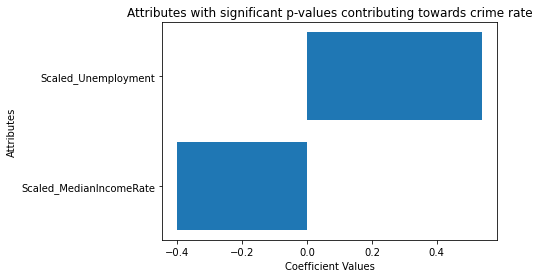

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     77.80
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.98e-38
Time:                        16:45:22   Log-Likelihood:                 121.94
No. Observations:                 110   AIC:                            -227.9
Df Residuals:                     102   BIC:                            -206.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

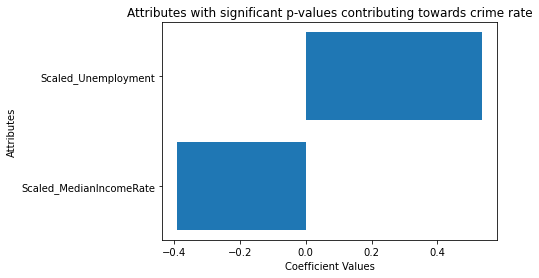

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     24.72
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.80e-15
Time:                        16:45:22   Log-Likelihood:                 29.632
No. Observations:                 132   AIC:                            -49.26
Df Residuals:                     127   BIC:                            -34.85
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

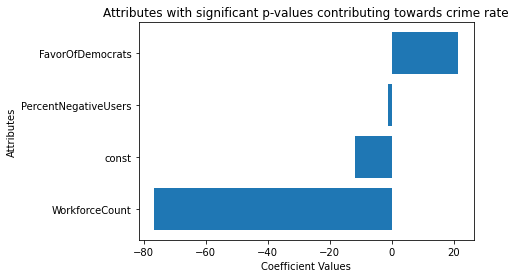


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     327.8
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           7.19e-60
Time:                        16:45:22   Log-Likelihood:                 134.28
No. Observations:                 132   AIC:                            -260.6
Df Residuals:                     128   BIC:                            -249.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

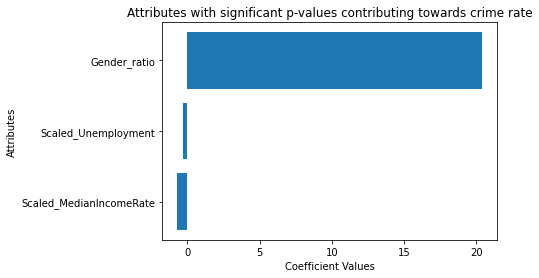

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     143.6
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.41e-56
Time:                        16:45:22   Log-Likelihood:                 137.43
No. Observations:                 132   AIC:                            -258.9
Df Residuals:                     124   BIC:                            -235.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

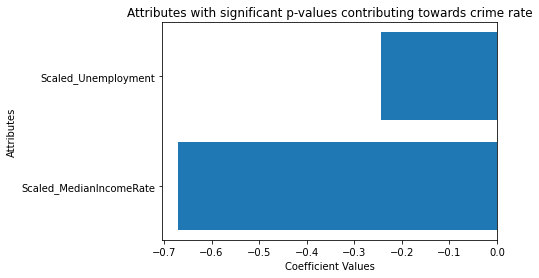

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     24.72
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.80e-15
Time:                        16:45:22   Log-Likelihood:                 29.632
No. Observations:                 132   AIC:                            -49.26
Df Residuals:                     127   BIC:                            -34.85
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

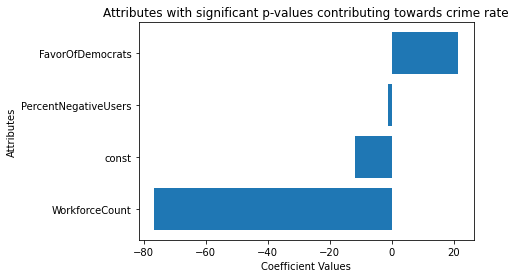


Covid Data Comparison:

Regression from Mar-2020 to Dec-2021 along with Covid Positive Cases Per Month:

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     4.200
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0125
Time:                        16:45:23   Log-Likelihood:                 39.654
No. Observations:                  22   AIC:                            -67.31
Df Residuals:                      16   BIC:                            -60.76
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1807615713.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_combined_dataset_covid['CovidPercPositive'] = perc


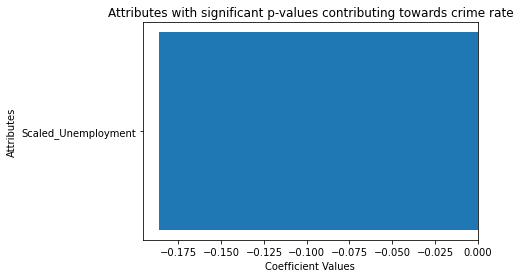


Regression for the same time frame without considering Covid Cases:

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     3.833
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0213
Time:                        16:45:23   Log-Likelihood:                 37.503
No. Observations:                  22   AIC:                            -65.01
Df Residuals:                      17   BIC:                            -59.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------

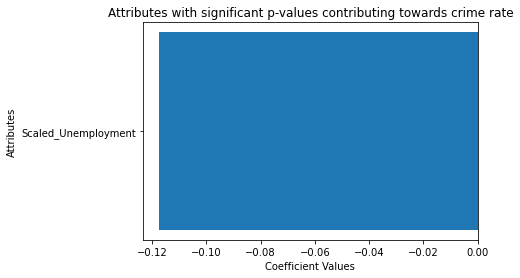


Correlation Graphs:



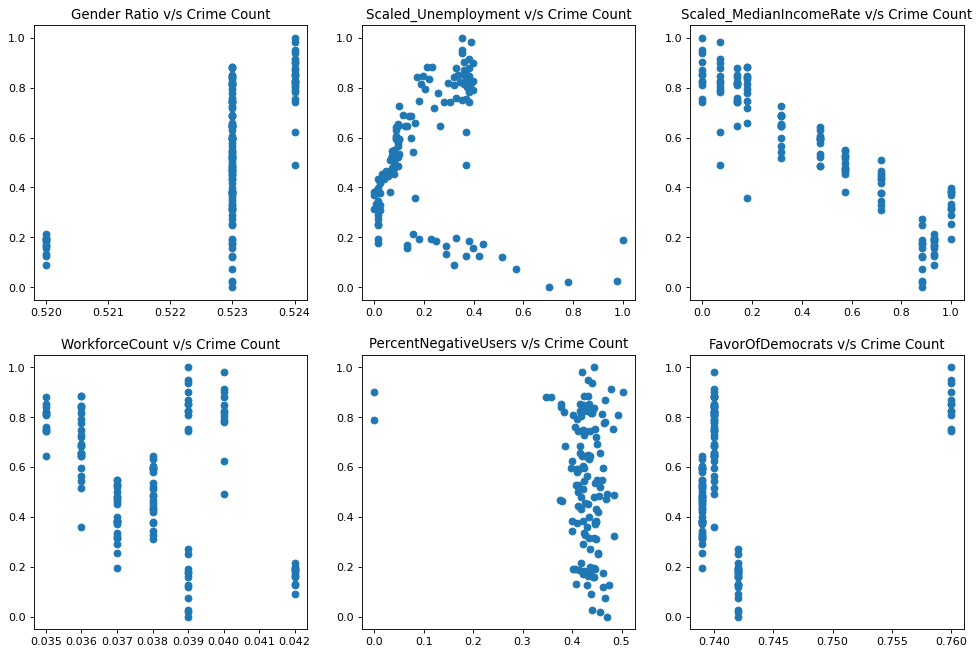

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

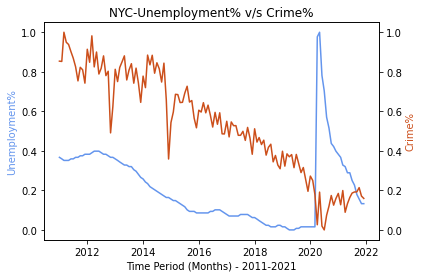



LA:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     224.9
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           8.48e-46
Time:                        16:45:23   Log-Likelihood:                 119.41
No. Observations:                 110   AIC:                            -230.8
Df Residuals:                     106   BIC:                            -220.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

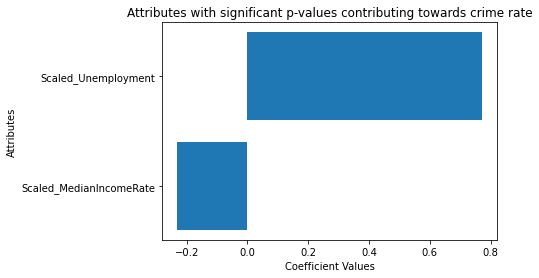

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     118.5
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.75e-46
Time:                        16:45:23   Log-Likelihood:                 131.23
No. Observations:                 110   AIC:                            -246.5
Df Residuals:                     102   BIC:                            -224.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

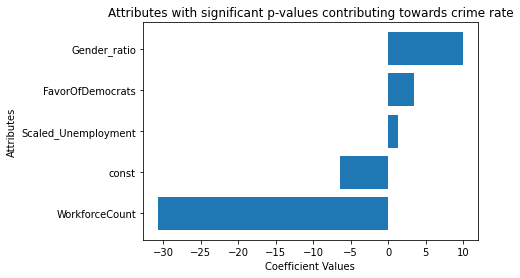

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     43.04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           8.83e-23
Time:                        16:45:24   Log-Likelihood:                 41.755
No. Observations:                 132   AIC:                            -73.51
Df Residuals:                     127   BIC:                            -59.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

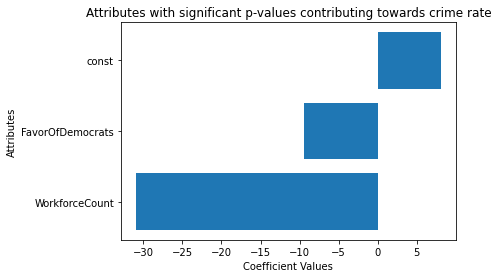


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     256.3
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           6.51e-54
Time:                        16:45:24   Log-Likelihood:                 113.70
No. Observations:                 132   AIC:                            -219.4
Df Residuals:                     128   BIC:                            -207.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

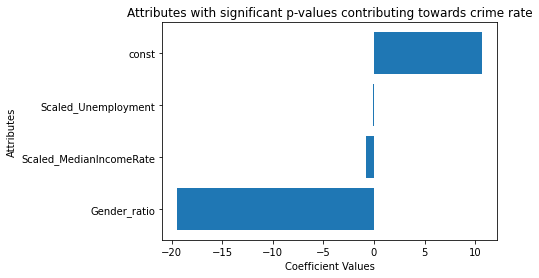

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     107.1
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.78e-49
Time:                        16:45:24   Log-Likelihood:                 114.08
No. Observations:                 132   AIC:                            -212.2
Df Residuals:                     124   BIC:                            -189.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

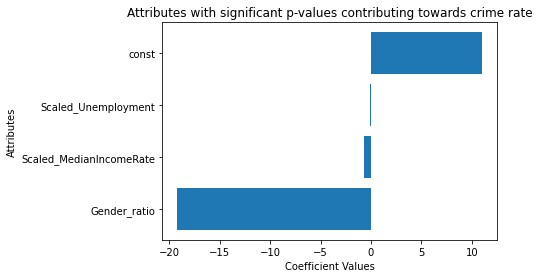

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     43.04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           8.83e-23
Time:                        16:45:24   Log-Likelihood:                 41.755
No. Observations:                 132   AIC:                            -73.51
Df Residuals:                     127   BIC:                            -59.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

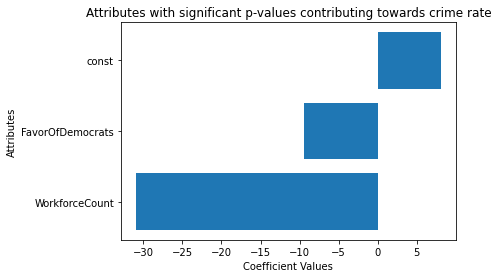


Covid Data Comparison:

Regression from Mar-2020 to Dec-2021 along with Covid Positive Cases Per Month:

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.101
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.398
Time:                        16:45:24   Log-Likelihood:                 33.988
No. Observations:                  22   AIC:                            -55.98
Df Residuals:                      16   BIC:                            -49.43
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1807615713.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_combined_dataset_covid['CovidPercPositive'] = perc


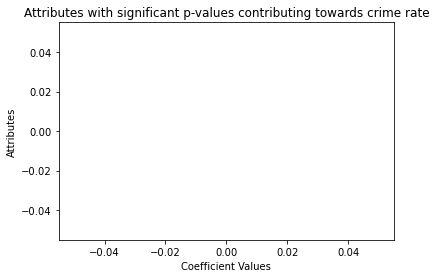


Regression for the same time frame without considering Covid Cases:

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.028
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.421
Time:                        16:45:24   Log-Likelihood:                 33.118
No. Observations:                  22   AIC:                            -56.24
Df Residuals:                      17   BIC:                            -50.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------

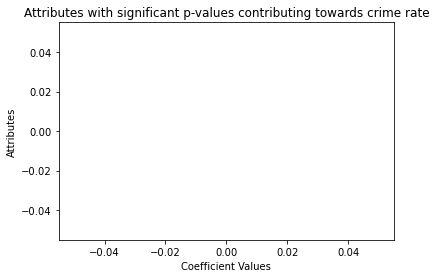


Correlation Graphs:



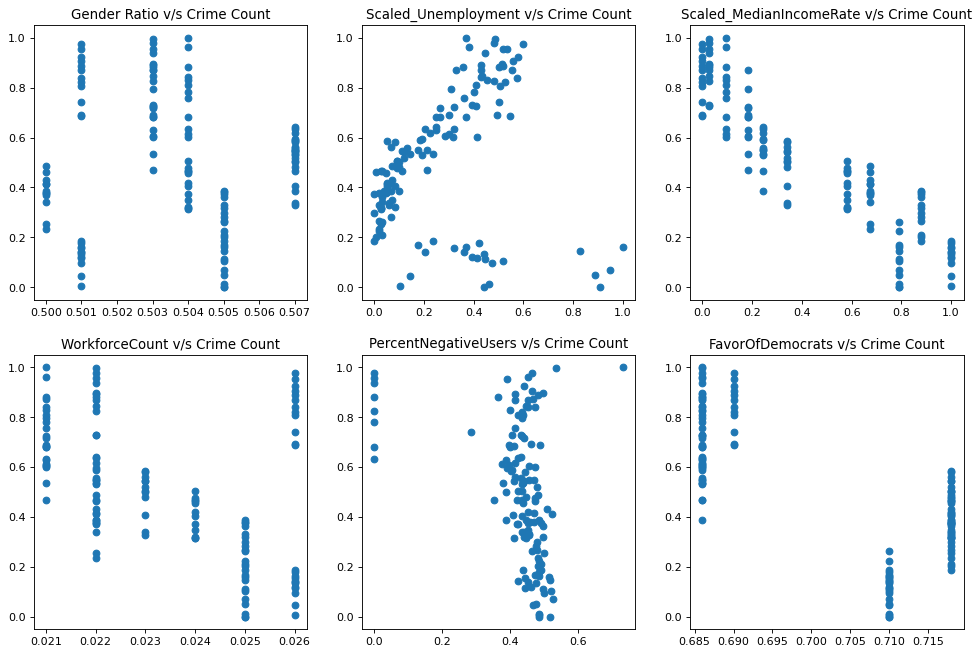

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

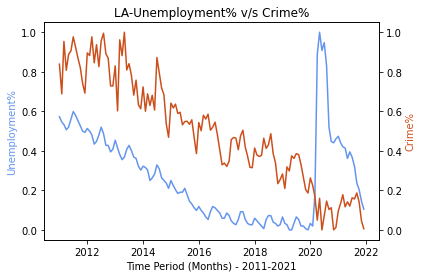



CHICAGO:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     122.8
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.33e-34
Time:                        16:45:25   Log-Likelihood:                 105.41
No. Observations:                 110   AIC:                            -202.8
Df Residuals:                     106   BIC:                            -192.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

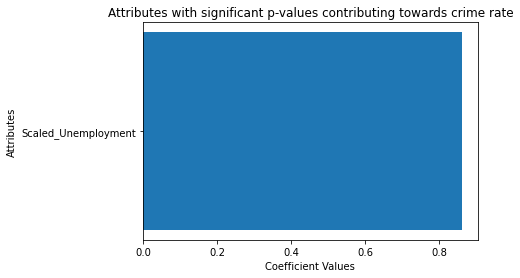

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     60.05
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.37e-33
Time:                        16:45:25   Log-Likelihood:                 112.82
No. Observations:                 110   AIC:                            -209.6
Df Residuals:                     102   BIC:                            -188.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

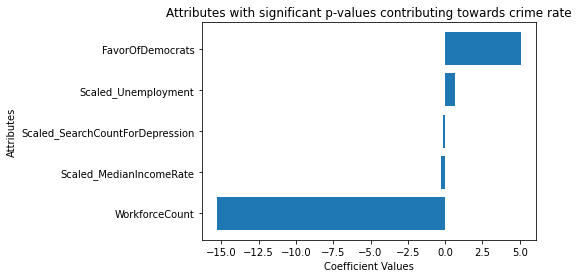

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     9.769
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           6.37e-07
Time:                        16:45:25   Log-Likelihood:                 12.958
No. Observations:                 132   AIC:                            -15.92
Df Residuals:                     127   BIC:                            -1.503
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

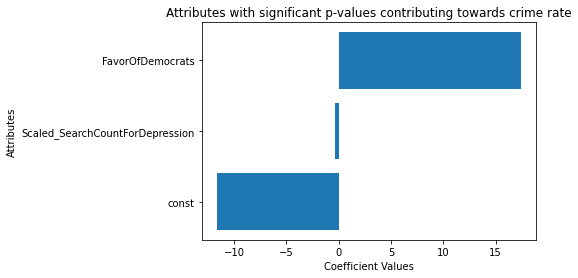


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     227.8
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.87e-51
Time:                        16:45:25   Log-Likelihood:                 117.15
No. Observations:                 132   AIC:                            -226.3
Df Residuals:                     128   BIC:                            -214.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

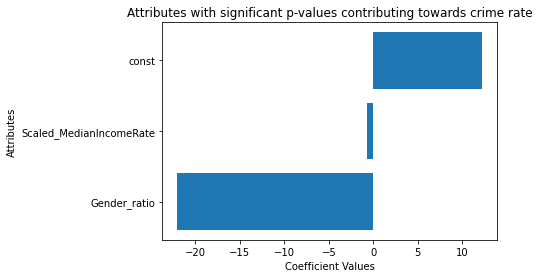

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     120.5
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.33e-52
Time:                        16:45:25   Log-Likelihood:                 130.85
No. Observations:                 132   AIC:                            -245.7
Df Residuals:                     124   BIC:                            -222.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

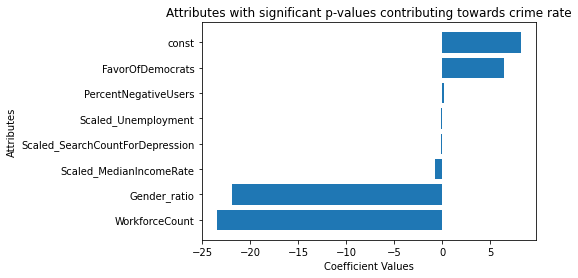

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     9.769
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           6.37e-07
Time:                        16:45:25   Log-Likelihood:                 12.958
No. Observations:                 132   AIC:                            -15.92
Df Residuals:                     127   BIC:                            -1.503
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

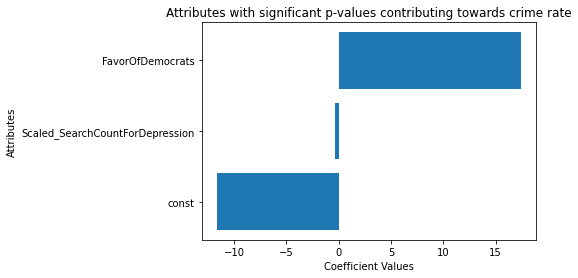


Covid Data Comparison:

Regression from Mar-2020 to Dec-2021 along with Covid Positive Cases Per Month:

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     3.082
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0389
Time:                        16:45:25   Log-Likelihood:                 41.161
No. Observations:                  22   AIC:                            -70.32
Df Residuals:                      16   BIC:                            -63.78
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1807615713.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_combined_dataset_covid['CovidPercPositive'] = perc


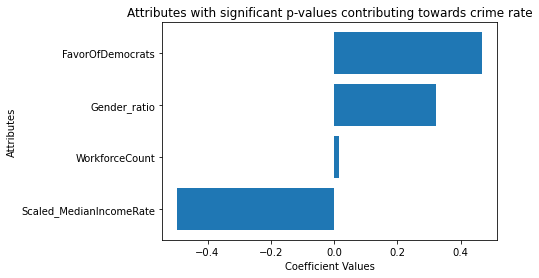


Regression for the same time frame without considering Covid Cases:

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     2.596
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0734
Time:                        16:45:25   Log-Likelihood:                 38.986
No. Observations:                  22   AIC:                            -67.97
Df Residuals:                      17   BIC:                            -62.52
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------

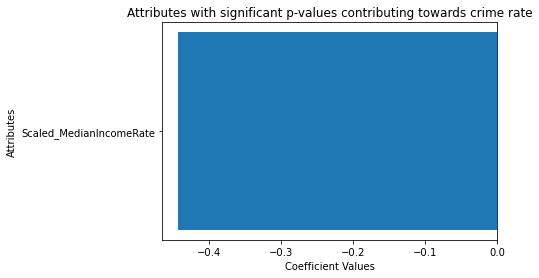


Correlation Graphs:



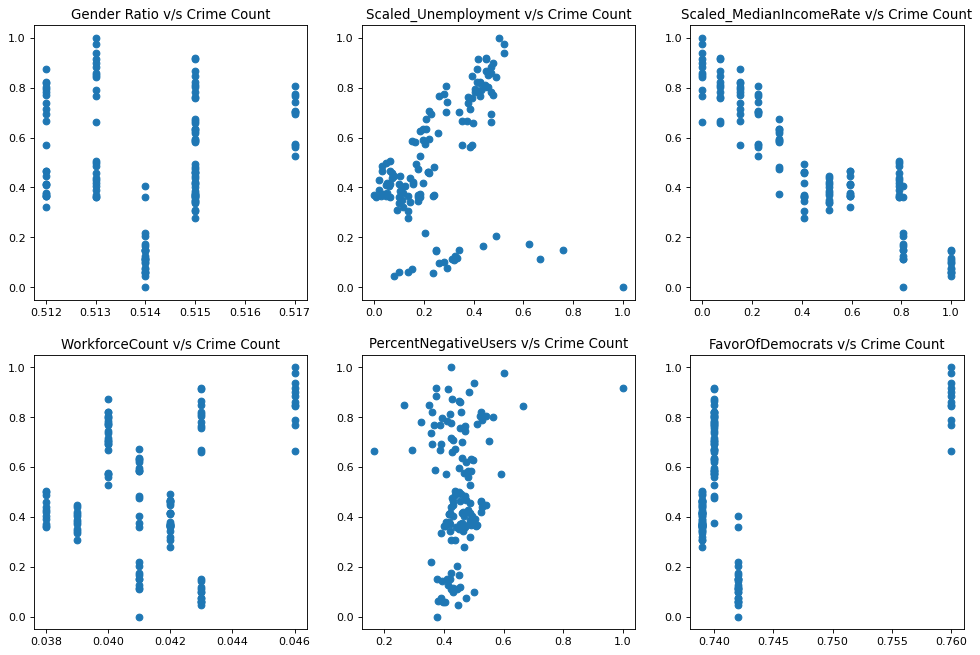

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

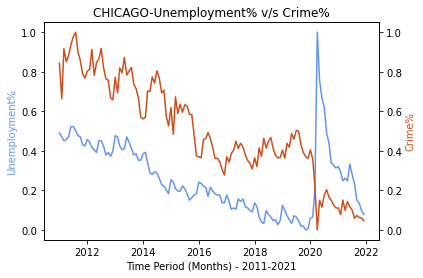



NASHVILLE:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.190
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.322
Time:                        16:45:26   Log-Likelihood:                 16.556
No. Observations:                  62   AIC:                            -25.11
Df Residuals:                      58   BIC:                            -16.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

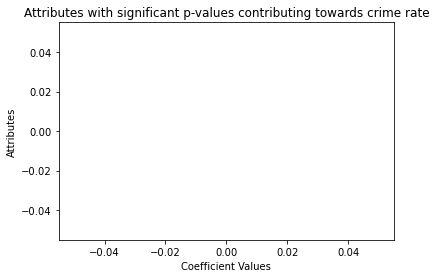

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     4.081
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00117
Time:                        16:45:26   Log-Likelihood:                 27.867
No. Observations:                  62   AIC:                            -39.73
Df Residuals:                      54   BIC:                            -22.72
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

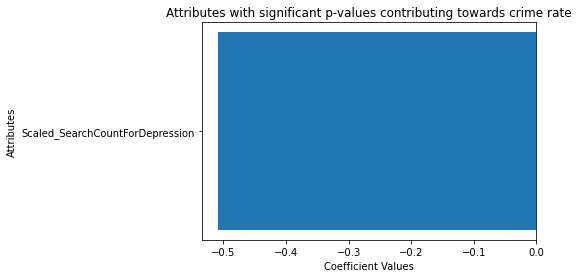

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     7.863
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.18e-05
Time:                        16:45:26   Log-Likelihood:                 25.564
No. Observations:                  84   AIC:                            -41.13
Df Residuals:                      79   BIC:                            -28.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

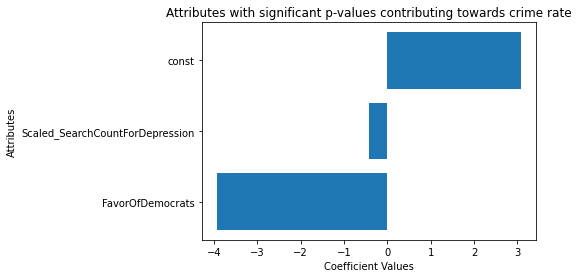


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.963
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0109
Time:                        16:45:26   Log-Likelihood:                 17.307
No. Observations:                  84   AIC:                            -26.61
Df Residuals:                      80   BIC:                            -16.89
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

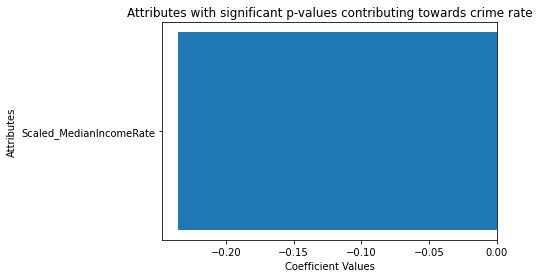

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     5.097
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           8.82e-05
Time:                        16:45:26   Log-Likelihood:                 27.655
No. Observations:                  84   AIC:                            -39.31
Df Residuals:                      76   BIC:                            -19.86
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

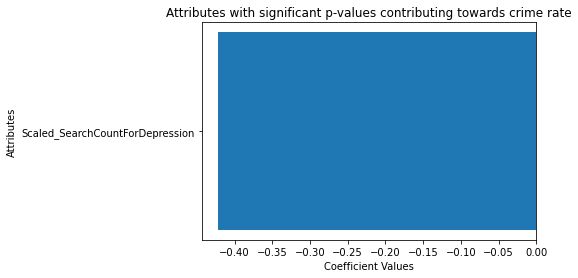

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     7.863
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.18e-05
Time:                        16:45:26   Log-Likelihood:                 25.564
No. Observations:                  84   AIC:                            -41.13
Df Residuals:                      79   BIC:                            -28.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

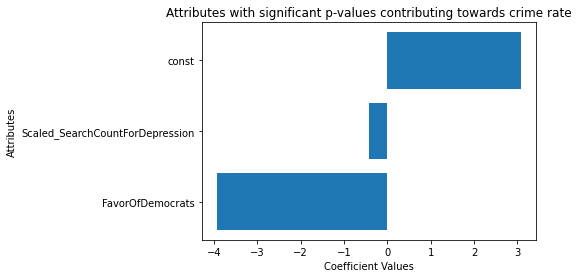


Correlation Graphs:



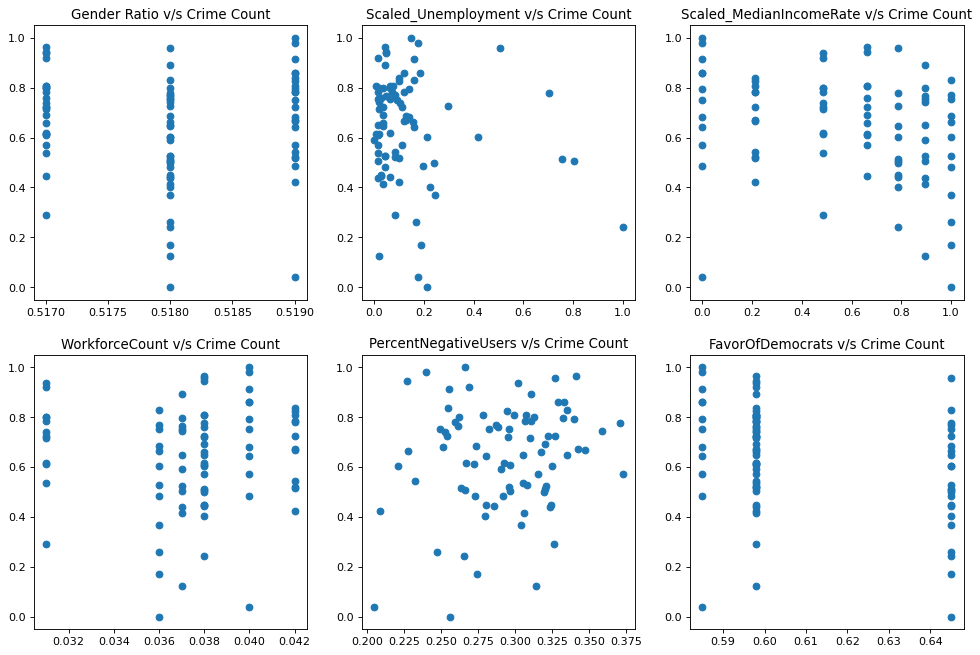

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

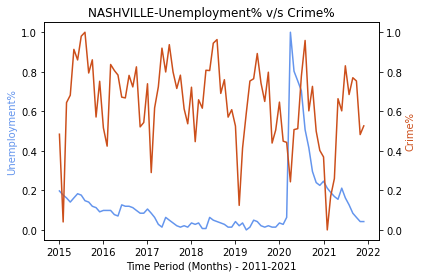



BOSTON:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     5.365
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00194
Time:                        16:45:27   Log-Likelihood:                 36.943
No. Observations:                  92   AIC:                            -65.89
Df Residuals:                      88   BIC:                            -55.80
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

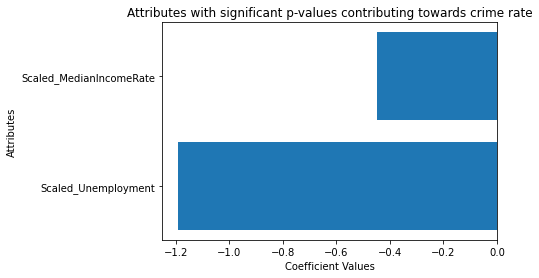

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     10.07
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.42e-09
Time:                        16:45:27   Log-Likelihood:                 57.244
No. Observations:                  92   AIC:                            -98.49
Df Residuals:                      84   BIC:                            -78.31
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

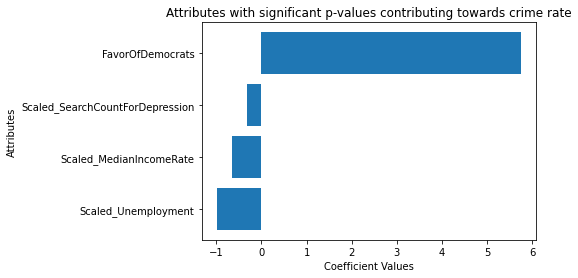

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.704
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00153
Time:                        16:45:27   Log-Likelihood:                 20.606
No. Observations:                 114   AIC:                            -31.21
Df Residuals:                     109   BIC:                            -17.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

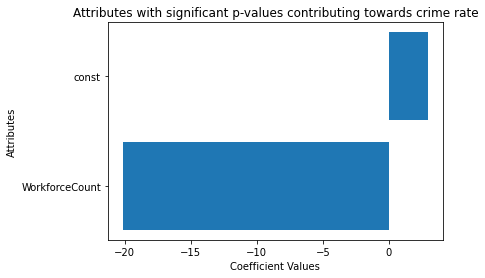


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     25.02
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.05e-12
Time:                        16:45:27   Log-Likelihood:                 41.175
No. Observations:                 114   AIC:                            -74.35
Df Residuals:                     110   BIC:                            -63.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

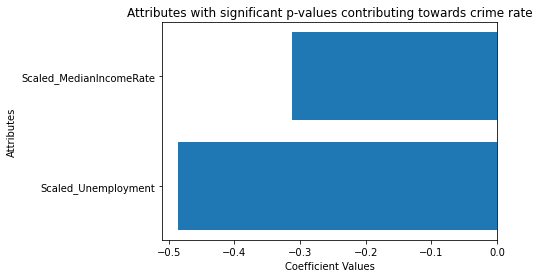

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     22.70
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.58e-18
Time:                        16:45:27   Log-Likelihood:                 63.738
No. Observations:                 114   AIC:                            -111.5
Df Residuals:                     106   BIC:                            -89.59
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

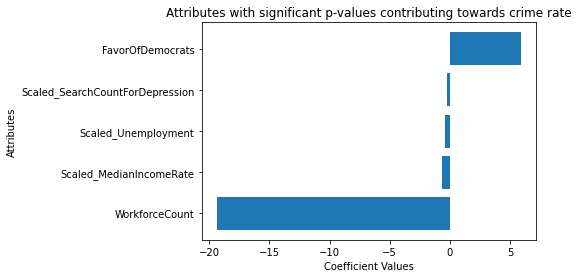

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.704
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00153
Time:                        16:45:27   Log-Likelihood:                 20.606
No. Observations:                 114   AIC:                            -31.21
Df Residuals:                     109   BIC:                            -17.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

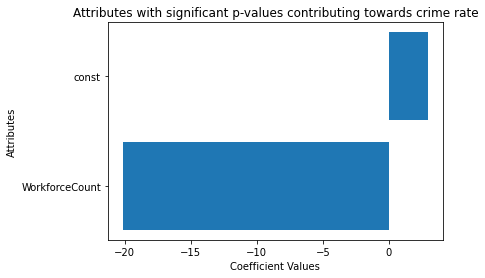


Correlation Graphs:



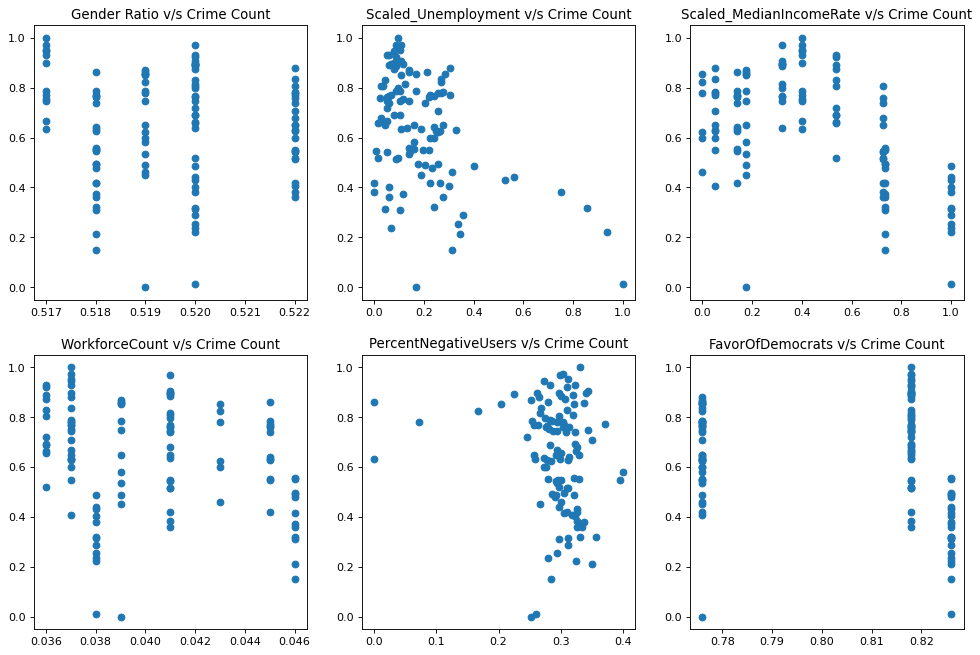

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

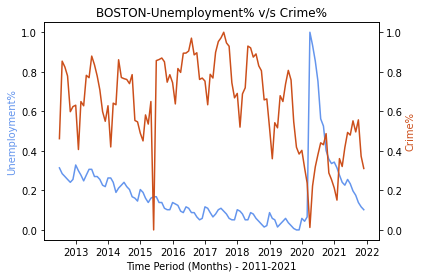



SEATTLE:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     7.701
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           0.000105
Time:                        16:45:28   Log-Likelihood:                 186.98
No. Observations:                 110   AIC:                            -366.0
Df Residuals:                     106   BIC:                            -355.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

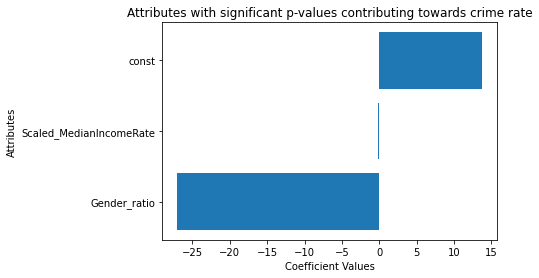

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     5.368
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.95e-05
Time:                        16:45:28   Log-Likelihood:                 193.39
No. Observations:                 110   AIC:                            -370.8
Df Residuals:                     102   BIC:                            -349.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

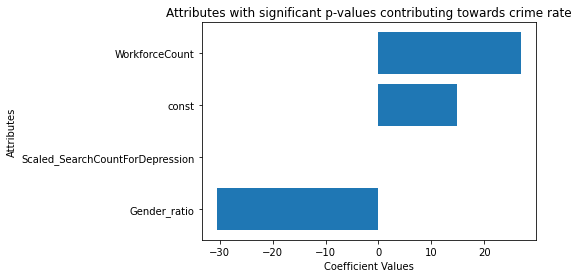

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2467
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.911
Time:                        16:45:28   Log-Likelihood:                 133.24
No. Observations:                 132   AIC:                            -256.5
Df Residuals:                     127   BIC:                            -242.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

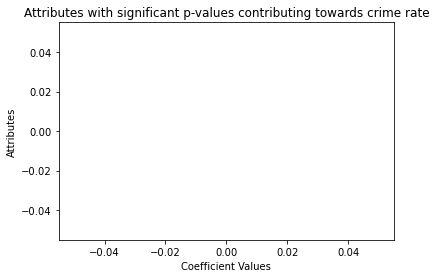


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     4.372
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00576
Time:                        16:45:28   Log-Likelihood:                 139.17
No. Observations:                 132   AIC:                            -270.3
Df Residuals:                     128   BIC:                            -258.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

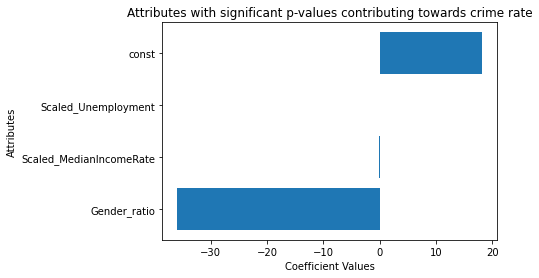

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.401
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0244
Time:                        16:45:28   Log-Likelihood:                 141.12
No. Observations:                 132   AIC:                            -266.2
Df Residuals:                     124   BIC:                            -243.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

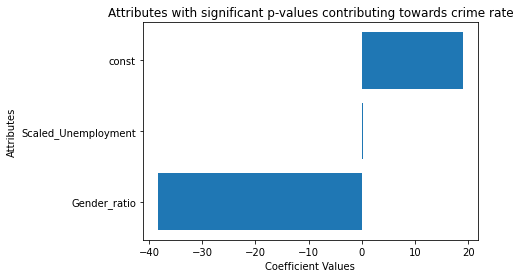

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2467
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.911
Time:                        16:45:28   Log-Likelihood:                 133.24
No. Observations:                 132   AIC:                            -256.5
Df Residuals:                     127   BIC:                            -242.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

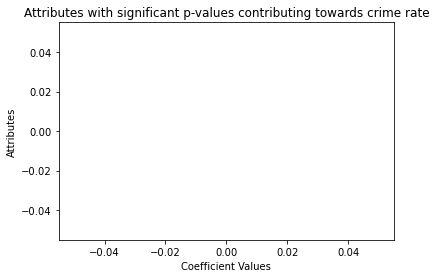


Correlation Graphs:



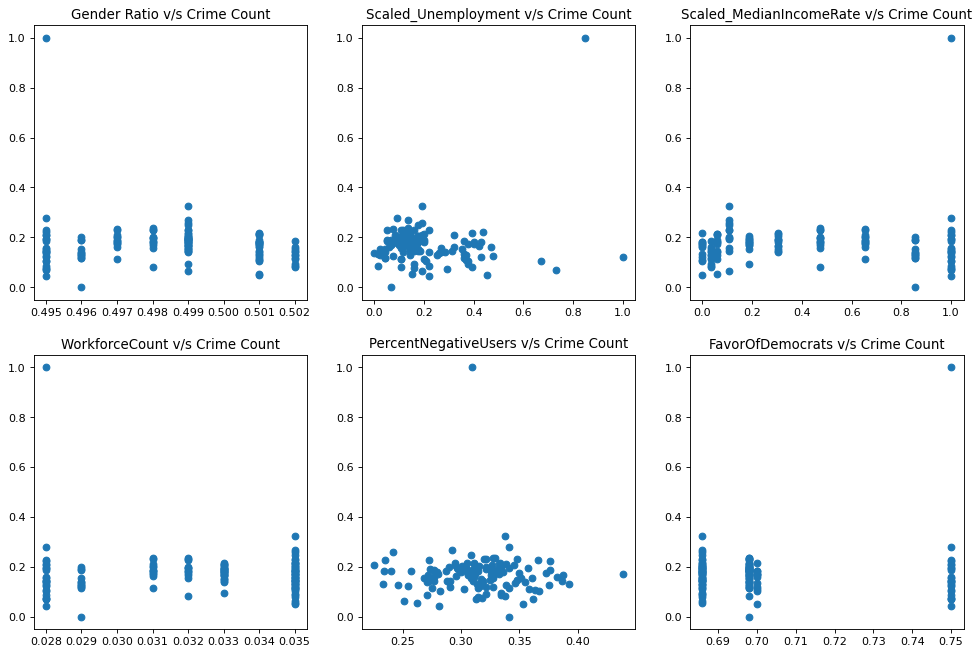

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

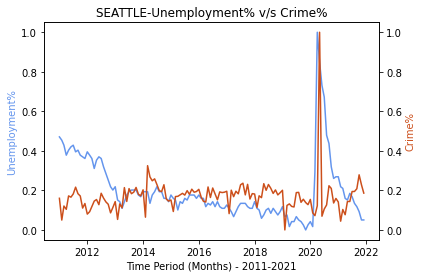



DENVER:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     144.8
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.41e-37
Time:                        16:45:29   Log-Likelihood:                 84.786
No. Observations:                 110   AIC:                            -161.6
Df Residuals:                     106   BIC:                            -150.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

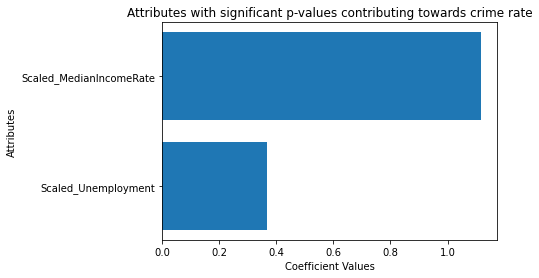

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     119.6
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.04e-46
Time:                        16:45:29   Log-Likelihood:                 117.32
No. Observations:                 110   AIC:                            -218.6
Df Residuals:                     102   BIC:                            -197.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

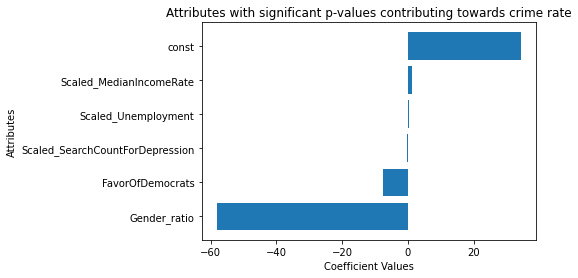

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     12.16
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.12e-08
Time:                        16:45:29   Log-Likelihood:                 26.188
No. Observations:                 132   AIC:                            -42.38
Df Residuals:                     127   BIC:                            -27.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

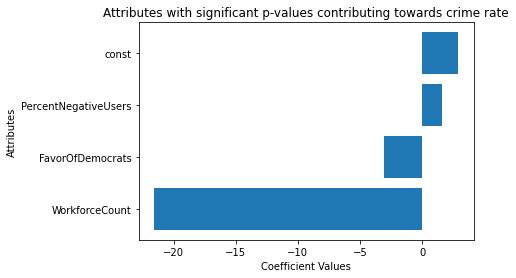


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     62.89
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.69e-25
Time:                        16:45:29   Log-Likelihood:                 64.567
No. Observations:                 132   AIC:                            -121.1
Df Residuals:                     128   BIC:                            -109.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

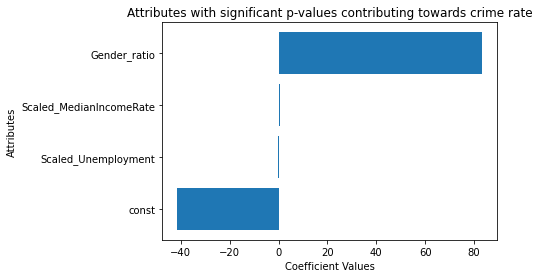

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     73.99
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.08e-41
Time:                        16:45:29   Log-Likelihood:                 113.30
No. Observations:                 132   AIC:                            -210.6
Df Residuals:                     124   BIC:                            -187.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

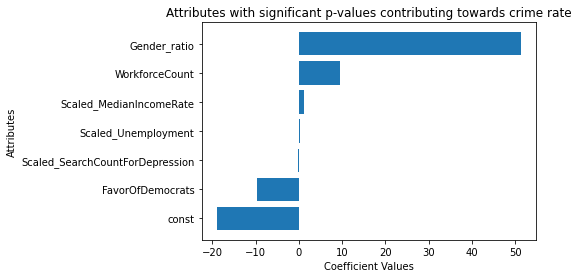

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     12.16
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.12e-08
Time:                        16:45:29   Log-Likelihood:                 26.188
No. Observations:                 132   AIC:                            -42.38
Df Residuals:                     127   BIC:                            -27.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

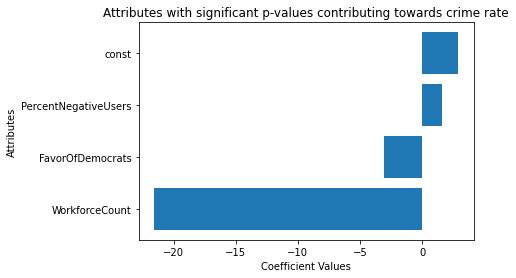


Correlation Graphs:



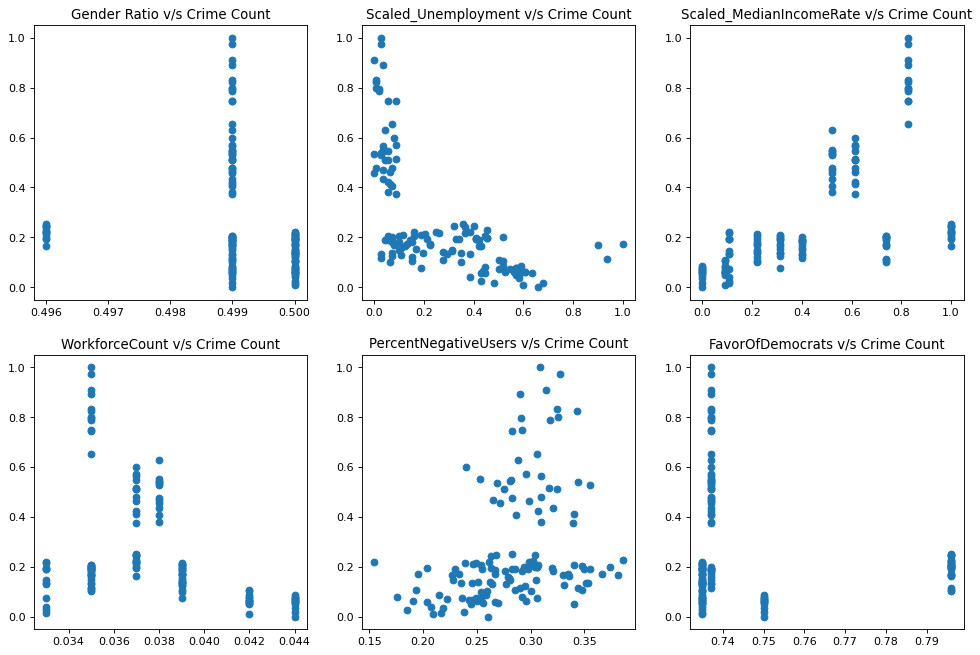

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

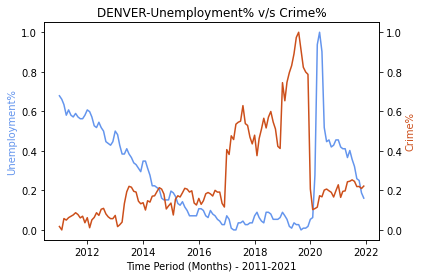



DALLAS:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     24.10
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.33e-10
Time:                        16:45:30   Log-Likelihood:                 41.919
No. Observations:                  69   AIC:                            -75.84
Df Residuals:                      65   BIC:                            -66.90
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

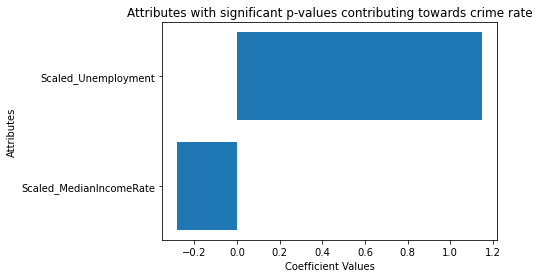

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     11.24
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.76e-09
Time:                        16:45:30   Log-Likelihood:                 44.706
No. Observations:                  69   AIC:                            -73.41
Df Residuals:                      61   BIC:                            -55.54
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

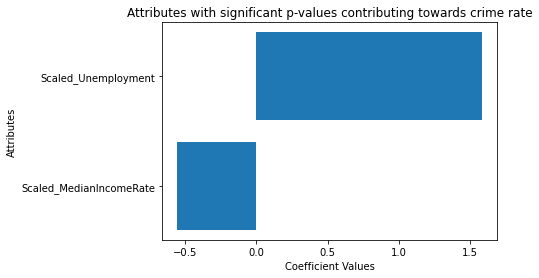

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     12.91
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.81e-08
Time:                        16:45:30   Log-Likelihood:                 36.864
No. Observations:                  91   AIC:                            -63.73
Df Residuals:                      86   BIC:                            -51.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

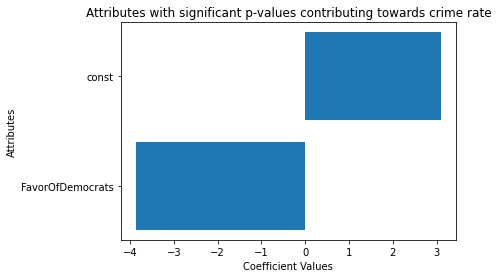


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     31.32
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           7.99e-14
Time:                        16:45:30   Log-Likelihood:                 48.780
No. Observations:                  91   AIC:                            -89.56
Df Residuals:                      87   BIC:                            -79.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

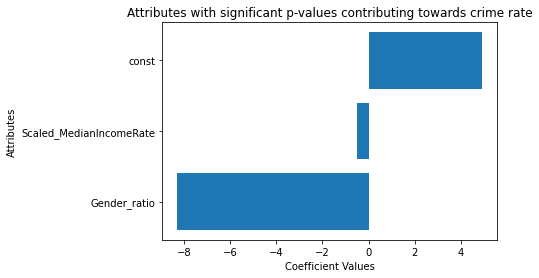

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.70e-11
Time:                        16:45:30   Log-Likelihood:                 49.448
No. Observations:                  91   AIC:                            -82.90
Df Residuals:                      83   BIC:                            -62.81
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

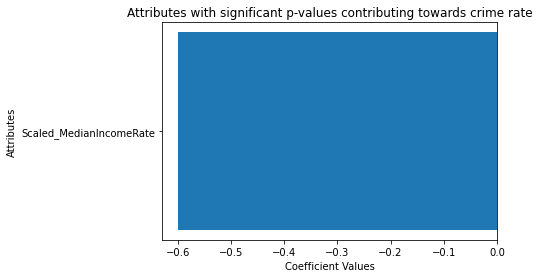

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     12.91
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.81e-08
Time:                        16:45:30   Log-Likelihood:                 36.864
No. Observations:                  91   AIC:                            -63.73
Df Residuals:                      86   BIC:                            -51.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

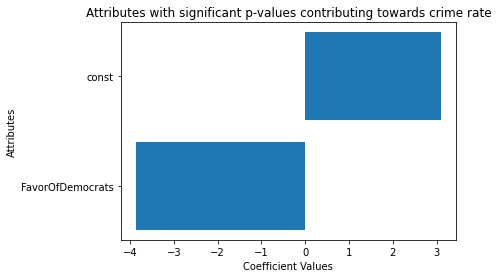


Correlation Graphs:



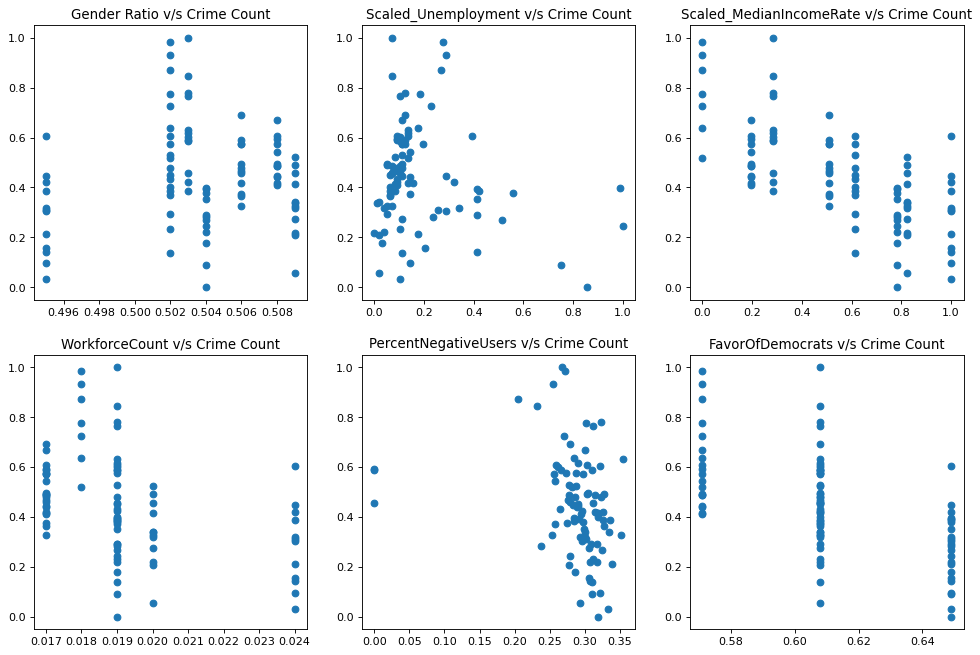

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

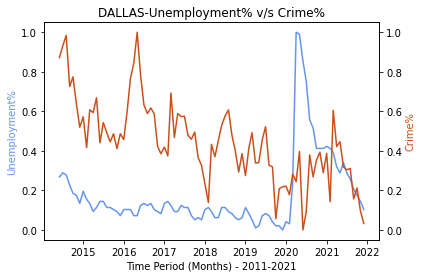



NEW_ORLEANS:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     7.432
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           0.000145
Time:                        16:45:31   Log-Likelihood:                 58.774
No. Observations:                 110   AIC:                            -109.5
Df Residuals:                     106   BIC:                            -98.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

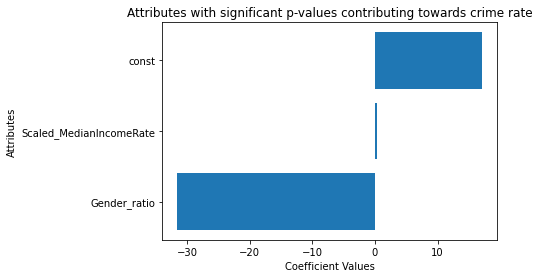

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     6.526
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.29e-06
Time:                        16:45:31   Log-Likelihood:                 68.629
No. Observations:                 110   AIC:                            -121.3
Df Residuals:                     102   BIC:                            -99.65
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

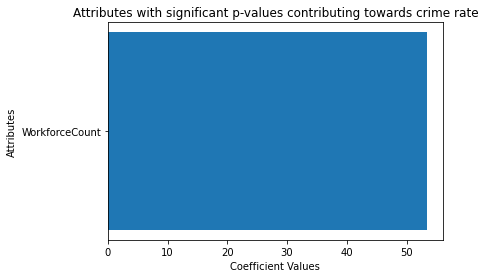

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     16.79
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.54e-11
Time:                        16:45:31   Log-Likelihood:                 82.423
No. Observations:                 132   AIC:                            -154.8
Df Residuals:                     127   BIC:                            -140.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

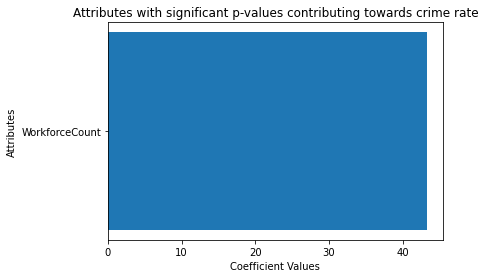


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     10.01
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.68e-06
Time:                        16:45:31   Log-Likelihood:                 68.319
No. Observations:                 132   AIC:                            -128.6
Df Residuals:                     128   BIC:                            -117.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

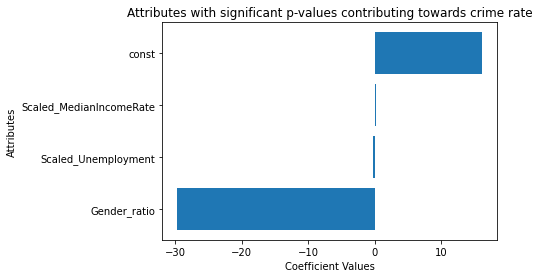

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     10.26
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.28e-10
Time:                        16:45:31   Log-Likelihood:                 84.559
No. Observations:                 132   AIC:                            -153.1
Df Residuals:                     124   BIC:                            -130.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

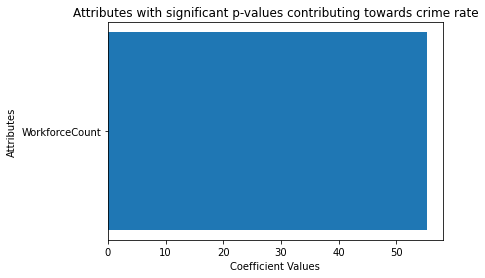

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     16.79
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.54e-11
Time:                        16:45:31   Log-Likelihood:                 82.423
No. Observations:                 132   AIC:                            -154.8
Df Residuals:                     127   BIC:                            -140.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

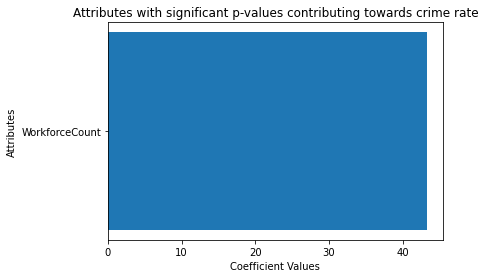


Correlation Graphs:



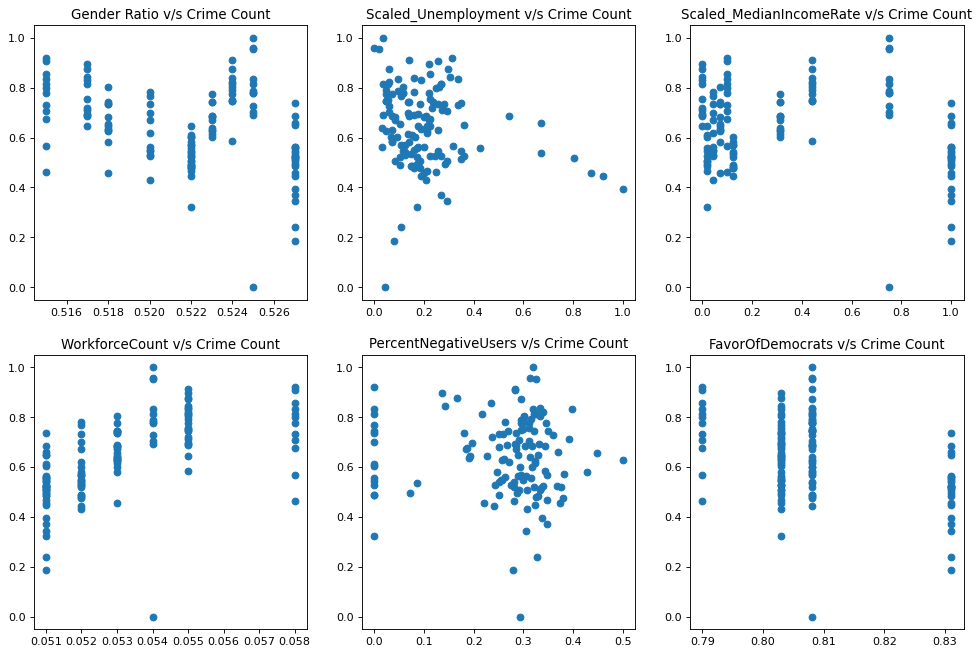

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

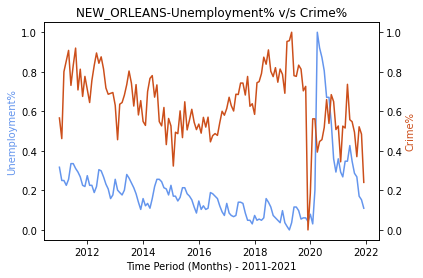



INDIANAPOLIS:


Before Covid (Mar-2020)


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     46.13
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.71e-19
Time:                        16:45:32   Log-Likelihood:                 80.659
No. Observations:                 110   AIC:                            -153.3
Df Residuals:                     106   BIC:                            -142.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

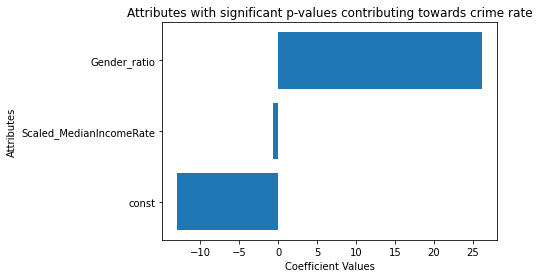

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     46.87
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           4.20e-29
Time:                        16:45:32   Log-Likelihood:                 113.86
No. Observations:                 110   AIC:                            -211.7
Df Residuals:                     102   BIC:                            -190.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

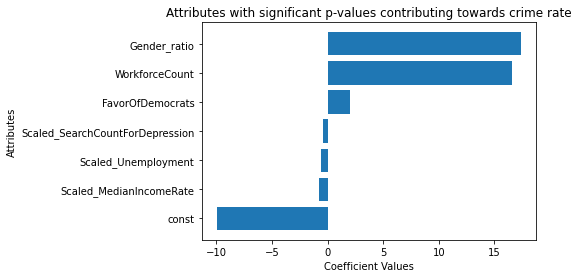

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     6.042
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           0.000175
Time:                        16:45:32   Log-Likelihood:                 45.280
No. Observations:                 132   AIC:                            -80.56
Df Residuals:                     127   BIC:                            -66.15
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

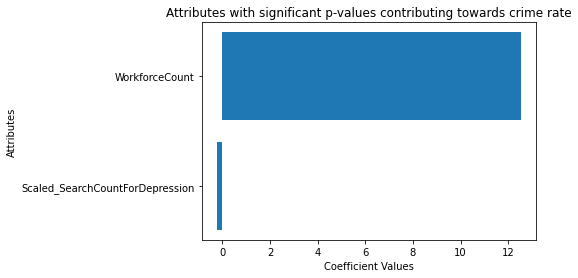


Till Dec-2021


Ground Truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     52.67
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.06e-22
Time:                        16:45:32   Log-Likelihood:                 86.845
No. Observations:                 132   AIC:                            -165.7
Df Residuals:                     128   BIC:                            -154.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

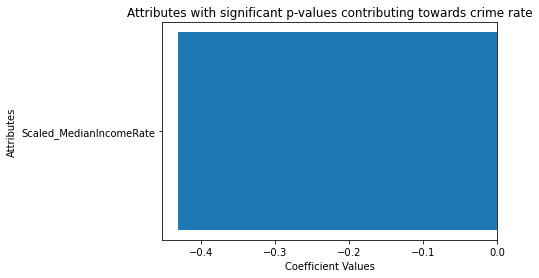

Our Model:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     70.26
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.94e-40
Time:                        16:45:32   Log-Likelihood:                 139.56
No. Observations:                 132   AIC:                            -263.1
Df Residuals:                     124   BIC:                            -240.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

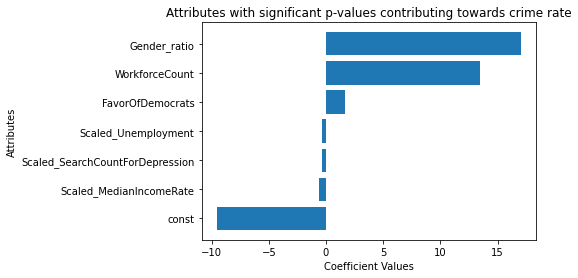

Our Model without ground truth:
Linear Model summary:
                             OLS Regression Results                            
Dep. Variable:      Scaled_CrimeCount   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     6.042
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           0.000175
Time:                        16:45:32   Log-Likelihood:                 45.280
No. Observations:                 132   AIC:                            -80.56
Df Residuals:                     127   BIC:                            -66.15
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

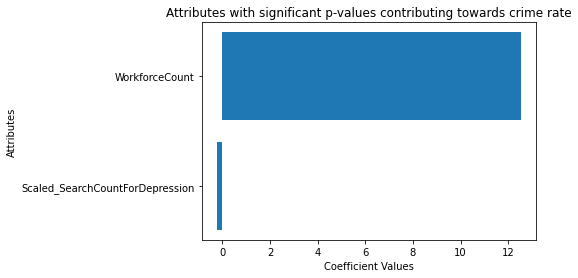


Correlation Graphs:



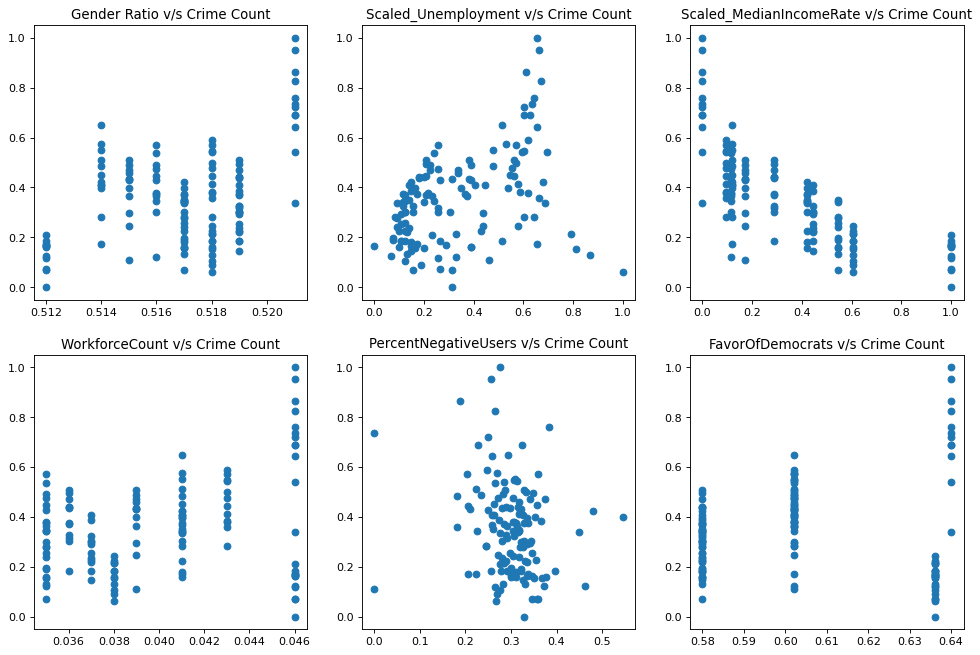

/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  ax1.plot(city_data["MonthYear"], city_data['Scaled_Unemployment'], 'g-', color="#6495ED")
/var/folders/j_/kdgw7x6d25j6yr_1c3mwp9m40000gn/T/ipykernel_39508/1320670805.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(city_data["MonthYear"], city_data['Scaled_CrimeCount'], 'b-', color="#CC4F1B")


<Figure size 2400x1200 with 0 Axes>

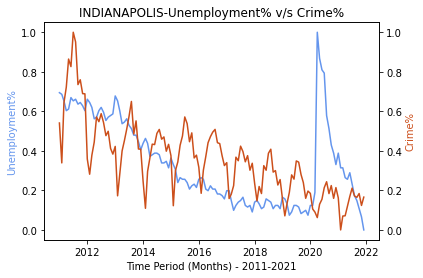


Before Covid (Mar-2020)




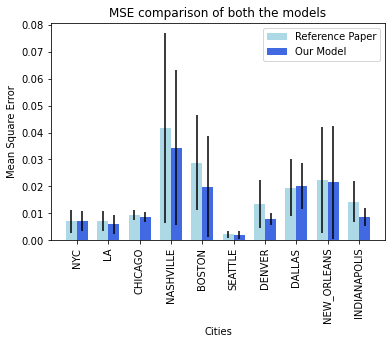


Till Dec-2021




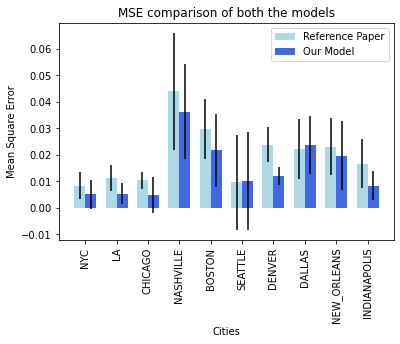

In [24]:
# Main Initiating Code Block

# cities_files = {'LA': 'CSV_LA_city_final_dataset_v2.csv','CHICAGO': 'chicago_city_final_dataset_v2.csv','NYC': 'NYC_final_dataset_v2.csv'}
cities = ["NYC", "LA", "CHICAGO", "NASHVILLE", "BOSTON", "SEATTLE", "DENVER", "DALLAS", "NEW_ORLEANS", "INDIANAPOLIS"]
# cities = ["LA"]
all_cities_df = []

for city_name in cities:
    print("\n\n{}:\n".format(city_name))
    city_file = "{}_final_dataset2.csv".format(city_name)
    infer_data(city_name, city_file, all_cities_df, absolute_file_path, normalize_original_data=True, poly_model=False)

print("\nBefore Covid (Mar-2020)\n\n")
plot_rmse(mse_our_model_before_covid, std_our_model_before_covid, mse_ground_truth_before_covid, std_ground_truth_before_covid, before_covid=True)
print("\nTill Dec-2021\n\n")
plot_rmse(mse_our_model, std_our_model, mse_ground_truth, std_ground_truth)

# infer_final_dataset_all_cities(all_cities_df)

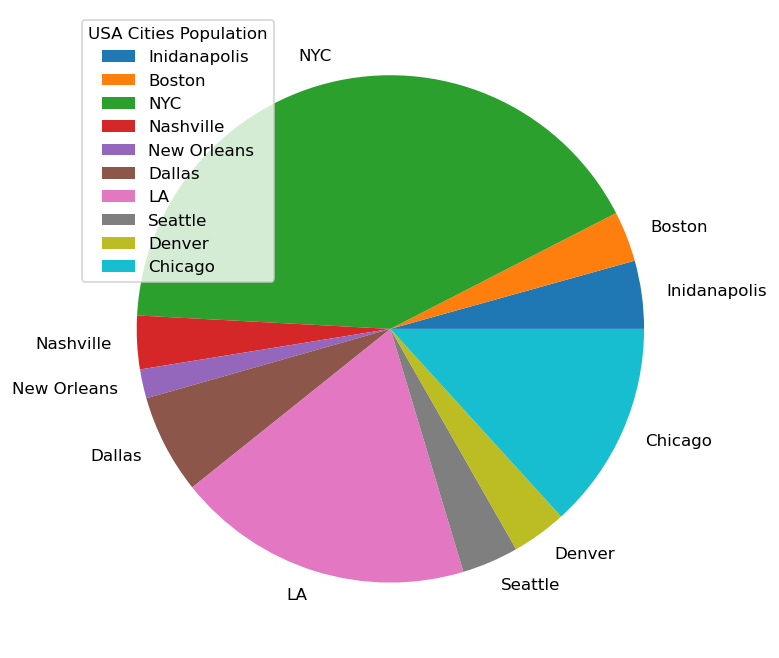

In [25]:
# USA Cities Population Pie Chart - Cities chosen for analysis for this project

USA = 331900000

total = 882039 + 654776 + 8468000 + 692587 + 376971 + 1288000 + 3849000 + 733919 + 711463 + 2697000

def get_pop_perc(pop):
#     return round(float(pop / USA) * 100, 2)
    return pop/total

inidanapolis = get_pop_perc(882039)
boston = get_pop_perc(654776)
nyc = get_pop_perc(8468000)
nashville = get_pop_perc(692587)
new_orleans = get_pop_perc(376971)
dallas = get_pop_perc(1288000)
la = get_pop_perc(3849000)
seattle = get_pop_perc(733919)
denver = get_pop_perc(711463)
chicago = get_pop_perc(2697000)

# others = float(100 - (inidanapolis + boston + nyc + nashville + new_orleans + dallas + la + seattle + denver + chicago))

figure(figsize=(8, 7), dpi=120)
labels = ["Inidanapolis", "Boston", "NYC", "Nashville", "New Orleans", "Dallas", "LA", "Seattle", "Denver", "Chicago"]
plt.pie([inidanapolis, boston, nyc, nashville, new_orleans, dallas, la, seattle, denver, chicago], labels=labels)
plt.legend(title = "USA Cities Population")
# plt.savefig('CitySelPopWise.png', transparent=True)
plt.show()

In [26]:
# Playing around with FamaMacBeth Algo, with Newey-West adjustment

# import pandas as pd
# from linearmodels import FamaMacBeth # import package
# ## 'panel' is a multi-index Pandas panel dataframe (stock code - date)
# panel = pd.read_csv('~/Downloads/Sample.csv')
# panel['date'] = pd.to_datetime(panel['Time'], format="%b-%y") # date should be `datetime` format
# panel = panel.set_index(['City', 'date']) # multi-index

# print(panel)

# mod = FamaMacBeth.from_formula('Output ~ 1 + Input1 + Input2 + Input3', data=panel)
# ## `bandwidth` is the lagged number of Newey-West, normally, bandwidth = 4(T/100) ^ (2/9)
# ## Remove all Settings in parentheses if newey-West adjustments are not required.
# res = mod.fit(cov_type= 'kernel',debiased = False, bandwidth = 3)
# print(res.summary)

In [27]:
# Barebone implementation of FamaMacBeth

# def ols_coef(x,formula):
#     return smf.ols(formula,data=x).fit().params
# panel = pd.read_csv('~/Downloads/Sample.csv')
# panel['date'] = pd.to_datetime(panel['Time'], format="%b-%y")
# gamma = (panel.groupby('date').apply(ols_coef,'Output ~ 1 + Input1 + Input2 + Input3'))
# print(gamma.head())

# def fm_summary(p):
#     s = p.describe().T
#     s['std_error'] = s['std']/np.sqrt(s['count'])
#     s['tstat'] = s['mean']/s['std_error']
#     return s[['mean','std_error','tstat']]
# print(fm_summary(gamma))

In [28]:
# Chicago Covid Comparison

# chicago_covid = pd.read_csv('~/Documents/Practice/Chicago_Covid.csv', header=None)
# chicago_covid.columns = ['Perc', 'MonthYear']
# chicago_covid['MonthYear'] = pd.to_datetime(chicago_covid['MonthYear'], format="%b-%Y")
# chicago_covid = chicago_covid.sort_values(by=['MonthYear'])
# # chicago_covid   # Mar2020 to Nov2022

# chicago_dataset = pd.read_csv('~/Documents/Practice/chicago_city_final_dataset_v2.csv')
# chicago_dataset['MonthYear'] = pd.to_datetime(chicago_dataset['MonthYear'], format="%b-%y")

# chicago_combined_dataset_covid = chicago_dataset[chicago_dataset['MonthYear'] >= '2020-03-01']

# perc = []
# for index, row in chicago_combined_dataset_covid.iterrows():
#     month_year = row['MonthYear']
#     perc_pos_covid_cases = chicago_covid[chicago_covid['MonthYear'] == month_year]['Perc']
#     perc.append(float(perc_pos_covid_cases))

# chicago_combined_dataset_covid['CovidPercPositive'] = perc

# regress_our_model_for_covid(chicago_combined_dataset_covid, 2)
# regress_our_model(chicago_combined_dataset_covid, 2)

In [29]:
# Trying out OLS Regression with multivariate implementation

# import statsmodels.api as sm

# city_data = pd.read_csv('~/Documents/Practice/CSV_LA_city_final_dataset_v2.csv')
# normalize_dataset(city_data)
# y = city_data['Scaled_CrimeCount']
# x = city_data.loc[:,['Gender_ratio', 'Scaled_Unemployment', 'Scaled_MedianIncomeRate']]

# X = sm.add_constant(x)
# lin_model = sm.OLS(y, X)
# regr_results = lin_model.fit()
# print(regr_results.summary())
# print(list(regr_results.params))

# transformer = PolynomialFeatures(degree=6, include_bias=False)
# x_ = transformer.fit_transform(x)
# x_ = pd.DataFrame(np.array(x_), columns=transformer.get_feature_names_out())
# X = sm.add_constant(x_)
# poly_model = sm.OLS(y, X)
# regr_results = poly_model.fit()
# print(regr_results.summary())

In [30]:
# Playing around with the interaction terms

# city_data = pd.read_csv("~/Documents/Practice/chicago_city_final_dataset_v2.csv".format(absolute_file_path, city_file), header=0)
# city_data = add_mental_health_data("CHICAGO", city_data, "~/Documents/Practice")
# y = city_data['Cul. Crime count']
# x = city_data.loc[:,['Gender_ratio', 'UnemploymentRate', 'MedianIncomeRate', 'WorkforceCount', 'PercentNegativeUsers', 'FavorOfDemocrats', 'SearchCountForDepression']]
# transformer = PolynomialFeatures(degree=2, include_bias=False)
# x_ = transformer.fit_transform(x)
# z = transformer.get_feature_names_out()

# # for idx, ele in enumerate(z):
# #     if idx in [3, 7, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 28, 30, 31]:
# #         print("{}: {}".format(idx, ele))
# # print(remove_interaction_terms(z, [19, 26, 33, 34]))
# # print(list(z[:10]) + list(z[11:19]) + list(z[20:31]) + list(z[32:]))

# # print(z[:7] + [z[12]] + [z[17]] + [z[21]] + [z[24]] + [z[26]])

# # Removing interaction terms
# new_x_ = []
# interaction_terms = [1, 8, 14, 17, 19, 22, 24, 26, 28, 29, 30, 31, 33]
# for item in x_:
# #     temp = list(item[:5]) + list(item[6:10]) + list(item[11:19]) + list(item[20:22]) + list(item[23:25]) + list(item[28:31]) + list(item[32:])
#     temp = remove_interaction_terms(item, interaction_terms)
#     new_x_.append(temp)

# # # # new_x_ = pd.DataFrame(np.array(new_x_), columns=list(z[:5]) + list(z[6:10]) + list(z[11:19]) + list(z[20:22]) + list(z[23:25]) + list(z[28:31]) + list(z[32:]))
# new_x_ = pd.DataFrame(np.array(new_x_), columns=remove_interaction_terms(z, interaction_terms))
# # new_x_ = pd.DataFrame(np.array(x_), columns=z)
# X = sm.add_constant(new_x_)
# regr_results = sm.OLS(list(y), X).fit()
# regr_results.summary()

In [31]:
# 0: Gender_ratio
# 1: UnemploymentRate
# 2: MedianIncomeRate
# 3: WorkforceCount
# 4: PercentNegativeUsers
# 5: FavorOfDemocrats
# 6: SearchCountForDepression
# 7: Gender_ratio^2
# 8: Gender_ratio UnemploymentRate
# 9: Gender_ratio MedianIncomeRate
# 10: Gender_ratio WorkforceCount
# 11: Gender_ratio PercentNegativeUsers
# 12: Gender_ratio FavorOfDemocrats
# 13: Gender_ratio SearchCountForDepression
# 14: UnemploymentRate^2
# 15: UnemploymentRate MedianIncomeRate
# 16: UnemploymentRate WorkforceCount
# 17: UnemploymentRate PercentNegativeUsers
# 18: UnemploymentRate FavorOfDemocrats
# 19: UnemploymentRate SearchCountForDepression
# 20: MedianIncomeRate^2
# 21: MedianIncomeRate WorkforceCount
# 22: MedianIncomeRate PercentNegativeUsers
# 23: MedianIncomeRate FavorOfDemocrats
# 24: MedianIncomeRate SearchCountForDepression
# 25: WorkforceCount^2
# 26: WorkforceCount PercentNegativeUsers
# 27: WorkforceCount FavorOfDemocrats
# 28: WorkforceCount SearchCountForDepression
# 29: PercentNegativeUsers^2
# 30: PercentNegativeUsers FavorOfDemocrats
# 31: PercentNegativeUsers SearchCountForDepression
# 32: FavorOfDemocrats^2
# 33: FavorOfDemocrats SearchCountForDepression
# 34: SearchCountForDepression^2